In [5]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import skew
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 데이터 로드

In [6]:
air_visit_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_visit_data.csv.zip')
air_store_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_store_info.csv.zip')
hpg_store_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/hpg_store_info.csv.zip')
air_reserve = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/air_reserve.csv.zip')
hpg_reserve = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/hpg_reserve.csv.zip')
store_id_relation = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/store_id_relation.csv.zip')
date_info = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/date_info.csv.zip')
weather_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/WeatherData.csv.zip')
area_name_mapping = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/area_name_mapping.zip')

#test_data input
sample_submission = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/sample_submission.csv.zip')

In [7]:
air_visit_data.head(5)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [8]:
air_store_info.shape

(829, 5)

In [9]:
hpg_store_info.shape

(4690, 5)

### 결측치 확인

In [10]:
print('*** air_reserve ***\n', air_reserve.isnull().sum())
print('*** hpg_reserve ***\n', hpg_reserve.isnull().sum())
print('*** store_id_relation ***\n', store_id_relation.isnull().sum())
print('*** air_info ***\n', air_store_info.isnull().sum())

*** air_reserve ***
 air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** hpg_reserve ***
 hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64
*** store_id_relation ***
 air_store_id    0
hpg_store_id    0
dtype: int64
*** air_info ***
 air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64


In [11]:
print('*** hpg_info ***\n', hpg_store_info.isnull().sum())
print('*** visit_data ***\n', air_visit_data.isnull().sum())
print('*** date_info ***\n', date_info.isnull().sum())
print('*** weather_data ***\n', weather_data.isnull().sum())
print('*** area_name_mapping ***\n', area_name_mapping.isnull().sum())

*** hpg_info ***
 hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64
*** visit_data ***
 air_store_id    0
visit_date      0
visitors        0
dtype: int64
*** date_info ***
 calendar_date    0
day_of_week      0
holiday_flg      0
dtype: int64
*** weather_data ***
 area_name                 0
calendar_date             0
precipitation          3623
avg_temperature        4152
total_snowfall        28911
deepest_snowfall      28404
hours_sunlight         7265
avg_wind_speed         4245
avg_vapor_pressure    23282
avg_humidity          23282
avg_sea_pressure      23265
avg_local_pressure    23265
solar_radiation       26884
cloud_cover           25850
high_temperature       4152
low_temperature        4152
dtype: int64
*** area_name_mapping ***
 air_area_name    0
station_id       0
dtype: int64


## 데이터 전처리

In [12]:
print("air의 예약된 식당 수: ", len(air_reserve['air_store_id'].unique()))
air_reserve.head()

air의 예약된 식당 수:  314


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [13]:
print("air에 정보가 있는 식당 수: ", len(air_store_info['air_store_id'].unique()))

air에 정보가 있는 식당 수:  829


In [14]:
print("hpg의 예약된 식당 수: ", len(hpg_reserve['hpg_store_id'].unique()))
hpg_reserve.head()

hpg의 예약된 식당 수:  13325


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [15]:
print("hpg에 정보가 있는 식당 수: ", len(hpg_store_info['hpg_store_id'].unique()))

hpg에 정보가 있는 식당 수:  4690


## info data

In [16]:
print("air와 hpg가 맵핑되어 있는 수: ", len(store_id_relation))
store_id_relation.head()

air와 hpg가 맵핑되어 있는 수:  150


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [17]:
#df_map을 info를 모아놓은 dataframe으로 생성
#hpg 데이터 기준으로 air에서의 아이디가 뭔지 column 생성
df_map = pd.merge(hpg_store_info, store_id_relation, on = 'hpg_store_id', how = 'outer')
df_map.tail(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
4772,hpg_265bd3fe806f8b6e,NaN,NaN,NaN,NaN,air_f96765e800907c77
4773,hpg_ef517ab154f66a8e,NaN,NaN,NaN,NaN,air_09661c0f3259cc04
4774,hpg_0cc0abae3a8b52de,NaN,NaN,NaN,NaN,air_b8925441167c3152
4775,hpg_1004356dc8ab69ec,NaN,NaN,NaN,NaN,air_6607fe3671242ce3
4776,hpg_df22bf146d2c7e19,NaN,NaN,NaN,NaN,air_ccd19a5bc5573ae5


In [18]:
df_map.head(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN


In [19]:
df_map.shape

(4777, 6)

#### hpg에 등록된 store 중 air에도 ID가 있는 가게는 4777개일까?

In [20]:
df_map.iloc[4680:4695]
#모든 hpg info의 가게가 air아이디가 있는건 아님

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
4680,hpg_cde530deaa97c31c,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4681,hpg_a74709cf53c76924,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4682,hpg_3c41f028563beac3,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,air_fc477473134e9ae5
4683,hpg_e60322667e14b99c,Amusement bar,Hokkaidō Sapporo-shi Minami 4 Jōnishi,43.055047,141.353236,NaN
4684,hpg_68637e2b90172cd3,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978,NaN
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453,NaN
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742,NaN
4689,hpg_11801306ce8bfb4f,Udon/Soba,Osaka Prefecture Osaka None,34.701519,135.498859,NaN


In [21]:
df_map_final = df_map.loc[(df_map['air_store_id'].isna()==False) & (df_map['hpg_store_id'].isna()==False)]
df_map_final

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id
98,hpg_cac091abfcee2a85,Japanese style,Tōkyō-to Chūō-ku Ginza,35.668600,139.763043,air_2aab19554f91ff82
150,hpg_e87d00be48cd91c6,Japanese style,Tōkyō-to Sumida-ku Tachibana,35.704960,139.828642,air_258ad2619d7bff9a
178,hpg_03795a62e1c5f1c3,Japanese style,Hiroshima-ken Hiroshima-shi Hondōri,34.392106,132.461914,air_c47aa7493b15f297
216,hpg_51fab1683266cd55,Japanese style,Ōsaka-fu Ōsaka-shi Shinsaibashisuji,34.669514,135.501425,air_96005f79124e12bf
351,hpg_9668001cf2b8dc74,Japanese style,Tōkyō-to Taitō-ku None,35.711353,139.782684,air_f2c5a1f24279c531
...,...,...,...,...,...,...
4772,hpg_265bd3fe806f8b6e,NaN,NaN,NaN,NaN,air_f96765e800907c77
4773,hpg_ef517ab154f66a8e,NaN,NaN,NaN,NaN,air_09661c0f3259cc04
4774,hpg_0cc0abae3a8b52de,NaN,NaN,NaN,NaN,air_b8925441167c3152
4775,hpg_1004356dc8ab69ec,NaN,NaN,NaN,NaN,air_6607fe3671242ce3


In [22]:
print("hpg중 air에도 아이디가 있는 가게: ", len(df_map_final['hpg_store_id'].unique()))

hpg중 air에도 아이디가 있는 가게:  150


#### hpg와 air 둘 다 ID가 있는 hpg info data는 150개

In [23]:
#air_store_info 데이터까지 hpg_store_info 데이터에 합쳐준다(air_store_id 기준으로)
df_final = pd.merge(df_map, air_store_info, on = 'air_store_id', how = 'outer')
df_final.shape

(5456, 10)

In [24]:
df_final.head(5)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_x,longitude_x,air_store_id,air_genre_name,air_area_name,latitude_y,longitude_y
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN


In [25]:
df_final.iloc[4773:4782]
df_final.reset_index(drop=True)

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_x,longitude_x,air_store_id,air_genre_name,air_area_name,latitude_y,longitude_y
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
5451,NaN,NaN,NaN,NaN,NaN,air_6b65745d432fd77f,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5452,NaN,NaN,NaN,NaN,NaN,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5453,NaN,NaN,NaN,NaN,NaN,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
5454,NaN,NaN,NaN,NaN,NaN,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051


In [26]:
df_final.shape

(5456, 10)

In [27]:
df_final.to_csv("store_count_outer.csv")

### 등록된 가게는 ***총 5456개***

## reserve data

In [28]:
#df_air = air_reserve + air_store_info (store id 정보가 있는 경우만 reserve에서 살려둠)
df_air = pd.merge(air_reserve, air_store_info, on = 'air_store_id')
print("air 예약 수: ", len(air_reserve))
print("air 예약 중 가게 정보 있는 수: ", len(df_air))
print(df_air.shape)
df_air.head(3)

air 예약 수:  92378
air 예약 중 가게 정보 있는 수:  92378
(92378, 8)


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [29]:
#df_hpg = hpg_reserve + hpg_store_info (store id 정보가 있는 경우만 reserve에서 살려둠)
df_hpg = pd.merge(hpg_reserve, hpg_store_info, on = 'hpg_store_id')
print("hpg 예약 수: ", len(hpg_reserve))
print("hpg 예약 중 가게 정보 있는 수: ", len(df_hpg))
print(df_hpg.shape)
df_hpg.head(3)

hpg 예약 수:  2000320
hpg 예약 중 가게 정보 있는 수:  871308
(871308, 8)


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
1,hpg_dac72789163a3f47,2016-01-02 12:00:00,2016-01-01 20:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698
2,hpg_dac72789163a3f47,2016-01-03 19:00:00,2016-01-02 15:00:00,2,French,Hyōgo-ken Kōbe-shi None,34.692109,135.191698


### column name 공통되게 변경
air_store_id, hpg_store_id > **id**   
air_genre_name, hpg_genre_name > **genre**   
air_area_name, hpg_area_name > **area_name**
   
**df_air_nc, df_hpg_nc로 각각 정의** 하여 concat한 data > **mixed_df**

In [30]:
df_air_nc = df_air.rename(columns = {"air_store_id":"id", "air_genre_name":"genre", "air_area_name": "area_name"}, inplace = False)
df_hpg_nc = df_hpg.rename(columns = {"hpg_store_id":"id", "hpg_genre_name":"genre", "hpg_area_name": "area_name"}, inplace = False)
mixed_df = pd.concat([df_air_nc, df_hpg_nc])
mixed_df.reset_index(drop=True)
mixed_df

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619


In [31]:
#visit_datetime(년-월-일-시간) 데이터를 년-월-일로 변경
df_ymd = mixed_df.copy()
df_ymd['visit_date'] = df_ymd['visit_datetime'].str.slice(start=0, stop=10)
df_ymd

,id,visit_datetime,reserve_datetime,reserve_visitors,genre,area_name,latitude,longitude,visit_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-01
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
3,air_877f79706adbfb06,2016-01-02 21:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-02
4,air_877f79706adbfb06,2016-01-08 21:00:00,2016-01-04 20:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,2016-01-08
...,...,...,...,...,...,...,...,...,...
871303,hpg_e106ddef2b137959,2017-04-24 18:00:00,2017-04-20 14:00:00,8,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871304,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,14,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871305,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-22 14:00:00,15,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24
871306,hpg_e106ddef2b137959,2017-04-24 19:00:00,2017-04-10 17:00:00,18,Japanese style,Tōkyō-to Chūō-ku None,35.682504,139.773619,2017-04-24


In [32]:
#같은 날, 같은 식당의 reserve_visitors 합치기
merged_df = df_ymd.groupby(by=['visit_date', 'id', 'genre','area_name','latitude','longitude'], as_index=False).sum()
merged_df.iloc[60:70]

C:\Users\piai\AppData\Local\Temp\ipykernel_2328\2154066644.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_df = df_ymd.groupby(by=['visit_date', 'id', 'genre','area_name','latitude','longitude'], as_index=False).sum()


,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors
60,2016-01-01,hpg_ea38f0f5b6ff6091,Japanese style,Tōkyō-to Chōfu-shi Fujimichō,35.664161,139.540969,2
61,2016-01-01,hpg_f23b00c038f70720,Japanese style,Shizuoka-ken Numazu-shi Yanagisawa,35.143507,138.824721,4
62,2016-01-01,hpg_f52ca09c98a38e07,International cuisine,Tōkyō-to Machida-shi Nakamachi,35.549670,139.448494,3
63,2016-01-01,hpg_f6117f6d2533237f,Grilled meat,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801,2
64,2016-01-01,hpg_f802d9079d5b1af3,Japanese style,Fukuoka-ken Fukuoka-shi Minamishō,33.576379,130.339313,2
65,2016-01-01,hpg_f92222c61d0adb11,International cuisine,Niigata-ken Niigata-shi Yoneyama,37.909809,139.062170,5
66,2016-01-02,air_2b8b29ddfd35018e,Okonomiyaki/Monja/Teppanyaki,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386244,132.455018,6
67,2016-01-02,air_3bb99a1fe0583897,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403,4
68,2016-01-02,air_6b15edd1b4fbb96a,Italian/French,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,11
69,2016-01-02,air_789466e488705c93,Izakaya,Fukuoka-ken Kurume-shi Jōnanmachi,33.319286,130.508374,67


In [33]:
#요일, holiday flag column 추가하기
date_info.head(2)

with_day_df = pd.merge(merged_df, date_info,left_on='visit_date',right_on='calendar_date')
with_day_df = with_day_df.drop(['calendar_date'], axis = 1)
with_day_df.head(3)

,visit_date,id,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,2016-01-01,air_877f79706adbfb06,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,3,Friday,1
1,2016-01-01,air_db4b38ebe7a7ceff,Dining bar,Ōsaka-fu Ōsaka-shi Shinmachi,34.676231,135.486059,9,Friday,1
2,2016-01-01,air_db80363d35f10926,Dining bar,Hokkaidō Asahikawa-shi 6 Jōdōri,43.770635,142.364819,5,Friday,1


In [34]:
#air_visit_data 이용해서 워크인, 노쇼 확인
air_visit_data.head(4)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22


In [35]:
check_no_show_df = pd.merge(air_visit_data, with_day_df, left_on = ['air_store_id', 'visit_date'],right_on=['id','visit_date'])
check_no_show_df2 = check_no_show_df.drop(['id','latitude','longitude', 'genre','area_name','day_of_week','holiday_flg'], axis = 1)
check_no_show_df2

#merge의 기본값은 inner, air_visit_data에 있는 가게만 나옴

,air_store_id,visit_date,visitors,reserve_visitors
0,air_35512c42db0868da,2016-02-27,6,12
1,air_ee3a01f0c71a769f,2016-01-04,61,2
2,air_ee3a01f0c71a769f,2016-01-08,21,3
3,air_ee3a01f0c71a769f,2016-01-09,57,25
4,air_ee3a01f0c71a769f,2016-01-10,32,5
...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,2
28060,air_754ae581ad80cc9f,2017-04-15,39,20
28061,air_754ae581ad80cc9f,2017-04-19,6,6
28062,air_754ae581ad80cc9f,2017-04-22,47,28


In [36]:
#예약인원과 실제 방문 고객 수 차이가 크기 때문에 예약 내용은 신경 안씀
#air_store_id, id값은 같으므로 id drop
visitor_df=check_no_show_df.drop(['id'], axis=1)
visitor_df.head(3)

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to Musashino-shi Midorichō,35.717784,139.56626,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.72594,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.72594,3,Friday,0


In [37]:
#genre 종류 확인
#visitor_df['genre'].unique()
visitor_df['genre'].value_counts(ascending=True)

Asian                              1
International cuisine              3
Karaoke/Party                     43
Other                            248
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [38]:
#genre 통합: Asian > other, International cuisine > other
genre_df = visitor_df.copy()
genre_df['genre'] = genre_df['genre'].replace('Asian', 'Other')
genre_df['genre'] = genre_df['genre'].replace('International cuisine', 'Other')
genre_df['genre'].value_counts(ascending=True)

Karaoke/Party                     43
Other                            252
Creative cuisine                 331
Bar/Cocktail                     426
Okonomiyaki/Monja/Teppanyaki     932
Western food                     950
Cafe/Sweets                     1290
Yakiniku/Korean food            1508
Japanese food                   3076
Dining bar                      3406
Italian/French                  6071
Izakaya                         9779
Name: genre, dtype: int64

In [39]:
#area_name에 none 있는지 확인
genre_df[genre_df['area_name'].isna()==True]

#없음

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg


In [40]:
#area_name에 none 있는지 확인
print(len(genre_df['area_name'].unique()))

# 동의 종류가 너무 다양해서 시를 기준으로 사용
si_df = genre_df.copy()
si_df['area_name'] = genre_df['area_name'].str.split(' ').str[0]
si_df['area_name'].value_counts(ascending=True)

71


Miyagi-ken        740
Niigata-ken      1025
Shizuoka-ken     1827
Ōsaka-fu         2039
Hiroshima-ken    2317
Hyōgo-ken        2415
Hokkaidō         3448
Fukuoka-ken      4382
Tōkyō-to         9871
Name: area_name, dtype: int64

In [41]:
area_df = si_df
area_df

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0
1,air_ee3a01f0c71a769f,2016-01-04,61,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,2,Monday,0
2,air_ee3a01f0c71a769f,2016-01-08,21,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,3,Friday,0
3,air_ee3a01f0c71a769f,2016-01-09,57,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,25,Saturday,0
4,air_ee3a01f0c71a769f,2016-01-10,32,Cafe/Sweets,Shizuoka-ken,34.710895,137.725940,5,Sunday,0
...,...,...,...,...,...,...,...,...,...,...
28059,air_754ae581ad80cc9f,2017-04-14,3,Izakaya,Niigata-ken,37.874223,138.971940,2,Friday,0
28060,air_754ae581ad80cc9f,2017-04-15,39,Izakaya,Niigata-ken,37.874223,138.971940,20,Saturday,0
28061,air_754ae581ad80cc9f,2017-04-19,6,Izakaya,Niigata-ken,37.874223,138.971940,6,Wednesday,0
28062,air_754ae581ad80cc9f,2017-04-22,47,Izakaya,Niigata-ken,37.874223,138.971940,28,Saturday,0


### 날씨데이터만 안합친 최종 데이터셋: area_df

In [42]:
#weather data의 리셋이 필요할 경우 활용할 셀
weather_data = pd.read_csv('../data/recruit-restaurant-visitor-forecasting/WeatherData.csv.zip')

In [43]:
#area_df에 weather data 합치기
weather_data.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [44]:
#weather_data의 결측치 확인
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33088 entries, 0 to 33087
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   area_name           33088 non-null  object 
 1   calendar_date       33088 non-null  object 
 2   precipitation       29465 non-null  float64
 3   avg_temperature     28936 non-null  float64
 4   total_snowfall      4177 non-null   float64
 5   deepest_snowfall    4684 non-null   float64
 6   hours_sunlight      25823 non-null  float64
 7   avg_wind_speed      28843 non-null  float64
 8   avg_vapor_pressure  9806 non-null   float64
 9   avg_humidity        9806 non-null   float64
 10  avg_sea_pressure    9823 non-null   float64
 11  avg_local_pressure  9823 non-null   float64
 12  solar_radiation     6204 non-null   float64
 13  cloud_cover         7238 non-null   float64
 14  high_temperature    28936 non-null  float64
 15  low_temperature     28936 non-null  float64
dtypes: f

In [45]:
print(weather_data['total_snowfall'].isnull().sum())
print(weather_data['deepest_snowfall'].isnull().sum())
print(weather_data['avg_vapor_pressure'].isnull().sum())
print(weather_data['avg_humidity'].isnull().sum())
print(weather_data['avg_sea_pressure'].isnull().sum())
print(weather_data['avg_local_pressure'].isnull().sum())
print(weather_data['solar_radiation'].isnull().sum())
print(weather_data['cloud_cover'].isnull().sum())

28911
28404
23282
23282
23265
23265
26884
25850


In [46]:
#calandar_date를 날짜 데이터로
weather_data['calendar_date'] = pd.to_datetime(weather_data['calendar_date'])
weather_data.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [47]:
#column 합치기를 위해 visit_date로 이름을 바꿔줌
weather_data = weather_data.rename(columns={'calendar_date':'visit_date'})
weather_data.head()

,area_name,visit_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [48]:
#합칠 area_df도 날짜형식으로 바꿔줌
area_df['visit_date']=pd.to_datetime(area_df['visit_date']) 
area_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28064 entries, 0 to 28063
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   air_store_id      28064 non-null  object        
 1   visit_date        28064 non-null  datetime64[ns]
 2   visitors          28064 non-null  int64         
 3   genre             28064 non-null  object        
 4   area_name         28064 non-null  object        
 5   latitude          28064 non-null  float64       
 6   longitude         28064 non-null  float64       
 7   reserve_visitors  28064 non-null  int64         
 8   day_of_week       28064 non-null  object        
 9   holiday_flg       28064 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.4+ MB


In [49]:
#결측치가 과하게 많은 column은 drop
weather_data = weather_data.drop(['total_snowfall','deepest_snowfall','avg_vapor_pressure','avg_humidity','avg_local_pressure','solar_radiation','cloud_cover'], axis=1)
weather_data

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,5.1,1.9,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,1.3,2.2,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,0.5,0.9,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,4.2,1.8,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,0.0,0.8,NaN,12.3,7.1
...,...,...,...,...,...,...,...,...,...
33083,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-27,NaN,19.2,13.5,2.3,1012.5,23.6,14.3
33084,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-28,NaN,21.3,12.6,2.3,1014.2,28.0,15.7
33085,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-29,NaN,23.2,12.8,3.7,1012.8,27.7,19.2
33086,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-30,NaN,23.6,12.1,2.4,1010.6,28.8,19.4


In [50]:
#weather_data를 mapping data를 활용하여 station_id를 air_area_name으로 바꿔주기
#위험하니 사본으로
weather_data2 = weather_data.copy()

for i in range(len(weather_data2)):
    for j in range(len(area_name_mapping)):
        if weather_data2['area_name'][i] == area_name_mapping['station_id'][j]:
            weather_data2['area_name'][i] = area_name_mapping['air_area_name'][j]

C:\Users\piai\AppData\Local\Temp\ipykernel_2328\1256132039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data2['area_name'][i] = area_name_mapping['air_area_name'][j]


In [51]:
#weather data도 시만 남기고 주소를 수정함
weather_data2['area_name'] = weather_data2['area_name'].str.split(' ').str[0]
weather_data2['area_name'].value_counts(ascending=True)

fukuoka_dazaifu-kana_dasaif                            517
tokyo__hachioji-kana__hachi-auji                       517
shizuoka__shizuoka-airport-kana__shizuoka-kukou        517
shizuoka__shimizu-kana__shimizu                        517
shizuoka__fuji-kana__fuji                              517
shizuoka__amagiyama-kana__amagi-san                    517
osaka__yao-kana__yao                                   517
osaka__kumakura-kana__kumatri                          517
osaka__ibaraki-kana__ibaraki                           517
niigata__sanjo-kana__sangyo                            517
niigata__ogata-kana__ogata                             517
niigata__niitsu-kana__niits                            517
niigata__nakajo-kana__nakajo                           517
niigata__matsuhama-kana__matsuhama                     517
tokyo__ome-kana__NONE                                  517
miyagi_shiogama-kana_shioogama                         517
tokyo__toshima-kana__toshima                           5

In [52]:
#area_df와 weather_data 합치기(지역이름과 방문날짜가 같은거만 남김)
area_df2 = pd.merge(area_df, weather_data2, on=['area_name','visit_date'], how='inner')

In [53]:
area_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167090 entries, 0 to 167089
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      167090 non-null  object        
 1   visit_date        167090 non-null  datetime64[ns]
 2   visitors          167090 non-null  int64         
 3   genre             167090 non-null  object        
 4   area_name         167090 non-null  object        
 5   latitude          167090 non-null  float64       
 6   longitude         167090 non-null  float64       
 7   reserve_visitors  167090 non-null  int64         
 8   day_of_week       167090 non-null  object        
 9   holiday_flg       167090 non-null  int64         
 10  precipitation     149212 non-null  float64       
 11  avg_temperature   135062 non-null  float64       
 12  hours_sunlight    118385 non-null  float64       
 13  avg_wind_speed    134724 non-null  float64       
 14  avg_

In [54]:
#air_df 중 avg_sea_pressure는 데이터가 적으므로 drop
area_df2.drop(['avg_sea_pressure'],axis=1,inplace=True)
area_df2

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,NaN,NaN,NaN,NaN,NaN
1,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,NaN,NaN,NaN,NaN,NaN
2,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
3,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,8.2,9.5,6.0,12.0,3.3
4,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.1,10.4,2.7,12.4,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167085,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,0.0,28.9,10.4,2.3,34.1,24.4
167086,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,0.0,23.9,8.7,2.8,28.9,21.0
167087,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,NaN,29.0,10.0,2.9,33.3,25.7
167088,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,0.0,28.9,10.6,1.9,33.1,25.3


In [55]:
area_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167090 entries, 0 to 167089
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   air_store_id      167090 non-null  object        
 1   visit_date        167090 non-null  datetime64[ns]
 2   visitors          167090 non-null  int64         
 3   genre             167090 non-null  object        
 4   area_name         167090 non-null  object        
 5   latitude          167090 non-null  float64       
 6   longitude         167090 non-null  float64       
 7   reserve_visitors  167090 non-null  int64         
 8   day_of_week       167090 non-null  object        
 9   holiday_flg       167090 non-null  int64         
 10  precipitation     149212 non-null  float64       
 11  avg_temperature   135062 non-null  float64       
 12  hours_sunlight    118385 non-null  float64       
 13  avg_wind_speed    134724 non-null  float64       
 14  high

In [2]:
area_df2

NameError: name 'area_df2' is not defined

In [57]:
area_df2.to_csv("final_no_drop.csv")

In [58]:
#결측치 있는 row는 drop
area_nandrop_df = area_df2.dropna(axis=0)

In [59]:
area_nandrop_df = area_nandrop_df.reset_index(drop=True)

In [60]:
area_nandrop_df.to_csv("final.csv")

## sample_submission

In [61]:
sample_submission['air_store_id'] = sample_submission.id.apply(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['visit_date'] = pd.to_datetime(sample_submission.id.apply(lambda x: x.split('_')[-1]))
sample_submission.head()

,id,visitors,air_store_id,visit_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27


In [62]:
#sample_submission data(test data)에 포함된 모든 레스토랑 ID가 air_visit_data(훈련데이터)에 포함되어있는지 확인
test_data = sample_submission.air_store_id.unique()
train_data = air_visit_data.air_store_id.unique()

print("test data 수: ", len(test_data), "\ntrain data 수: ", len(train_data))

test data 수:  821 
train data 수:  829


In [63]:
#air_visit_data(훈련데이터) 중 sample_submission(테스트데이터)에 포함되지 않은 레스토랑 ID
set(train_data) - set(test_data)

{'air_0ead98dd07e7a82a',
 'air_229d7e508d9f1b5e',
 'air_2703dcb33192b181',
 'air_b2d8bc9c88b85f96',
 'air_cb083b4789a8d3a2',
 'air_cf22e368c1a71d53',
 'air_d0a7bd3339c3d12a',
 'air_d63cfa6d6ab78446'}

In [64]:
np.arange(len(test_data))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [65]:
#1단계: 테스트용 레스토랑 ID를 수치화하여 저장
list1 = list(test_data)
list2 = list(np.arange(len(test_data)))
air_id_dict = dict(zip(list1, list2))
air_id_reverse_dict = dict([*zip(air_id_dict.values(), air_id_dict.keys())])

#2단계: 레스토랑 ID로 훈련 데이터 초기화
train_data = pd.DataFrame({'air_store_id': test_data})
print('훈련데이터 수(train_data)：', len(train_data))
train_data.head()

훈련데이터 수(train_data)： 821


,air_store_id
0,air_00a91d42b08b08d9
1,air_0164b9927d20bcc3
2,air_0241aa3964b7f861
3,air_0328696196e46f18
4,air_034a3d5b40d5b1b1


In [66]:
#3단계: 훈련 데이터의 각 데이터에 대해 날짜를 취득, 방문자를 맵핑함
#훈련데이터: 2016-01-01  ~  2017-04-22

date_cols = pd.date_range(start='2016-01-01', end='2017-04-22').date.astype(str)



## **Feature 찾기**
#### (file_df = area_nandrop_df 사용)

In [67]:
# file load
file_df = area_nandrop_df.copy()
file_nandrop_df = area_df2.copy()

In [68]:
target_name = 'visitors'
no_need_features = ['air_store_id', 'visit_date']
category_features = ['genre', 'area_name', 'day_of_week', 'holiday_flg']

In [69]:
file_df.head(5)

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
1,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,8.2,9.5,6.0,12.0,3.3
2,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.1,10.4,2.7,12.4,1.6
3,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.3,10.1,2.2,13.2,2.6
4,air_082908692355165e,2016-02-27,27,Italian/French,Tōkyō-to,35.693840,139.703549,2,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3


In [70]:
# arrange X and y
file_df2 = file_df.drop(no_need_features, axis=1)
y_target = file_df[target_name]
X_features = file_df2.drop([target_name],axis=1,inplace=False)

In [71]:
X_features.head(3)

,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,Dining bar,Tōkyō-to,35.717784,139.56626,12,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
1,Dining bar,Tōkyō-to,35.717784,139.56626,12,Saturday,0,0.0,8.2,9.5,6.0,12.0,3.3
2,Dining bar,Tōkyō-to,35.717784,139.56626,12,Saturday,0,0.0,7.1,10.4,2.7,12.4,1.6


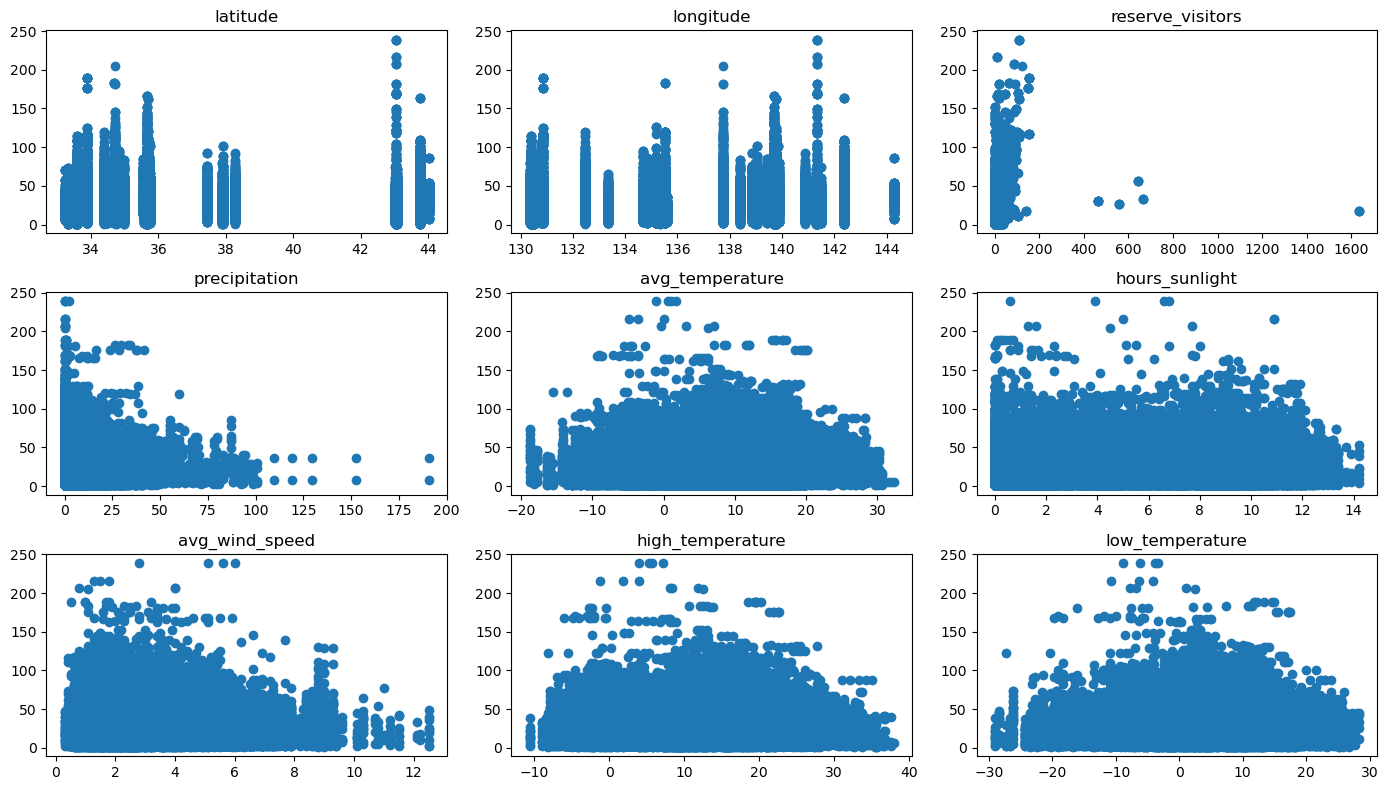

In [75]:
X_features_drop = X_features.drop(category_features, axis=1)
fig, axes = plt.subplots(3,3, figsize=(14,8))
column_list = list(X_features_drop.columns)

i = 0

for j in range(3):
    for k in range(3):
        axes[j,k].scatter(x = X_features_drop[column_list[i]], y = y_target)
        axes[j,k].set_title(column_list[i])
        i += 1
fig.tight_layout()
plt.show()

In [ ]:
# # visualize data to find outliers
# for feature in X_features.drop(category_features, axis=1, inplace=False):
#     plt.scatter(x = file_df[feature], y = y_target)
#     plt.ylabel(target_name, fontsize=15)
#     plt.xlabel(feature, fontsize=15)
#     plt.show()

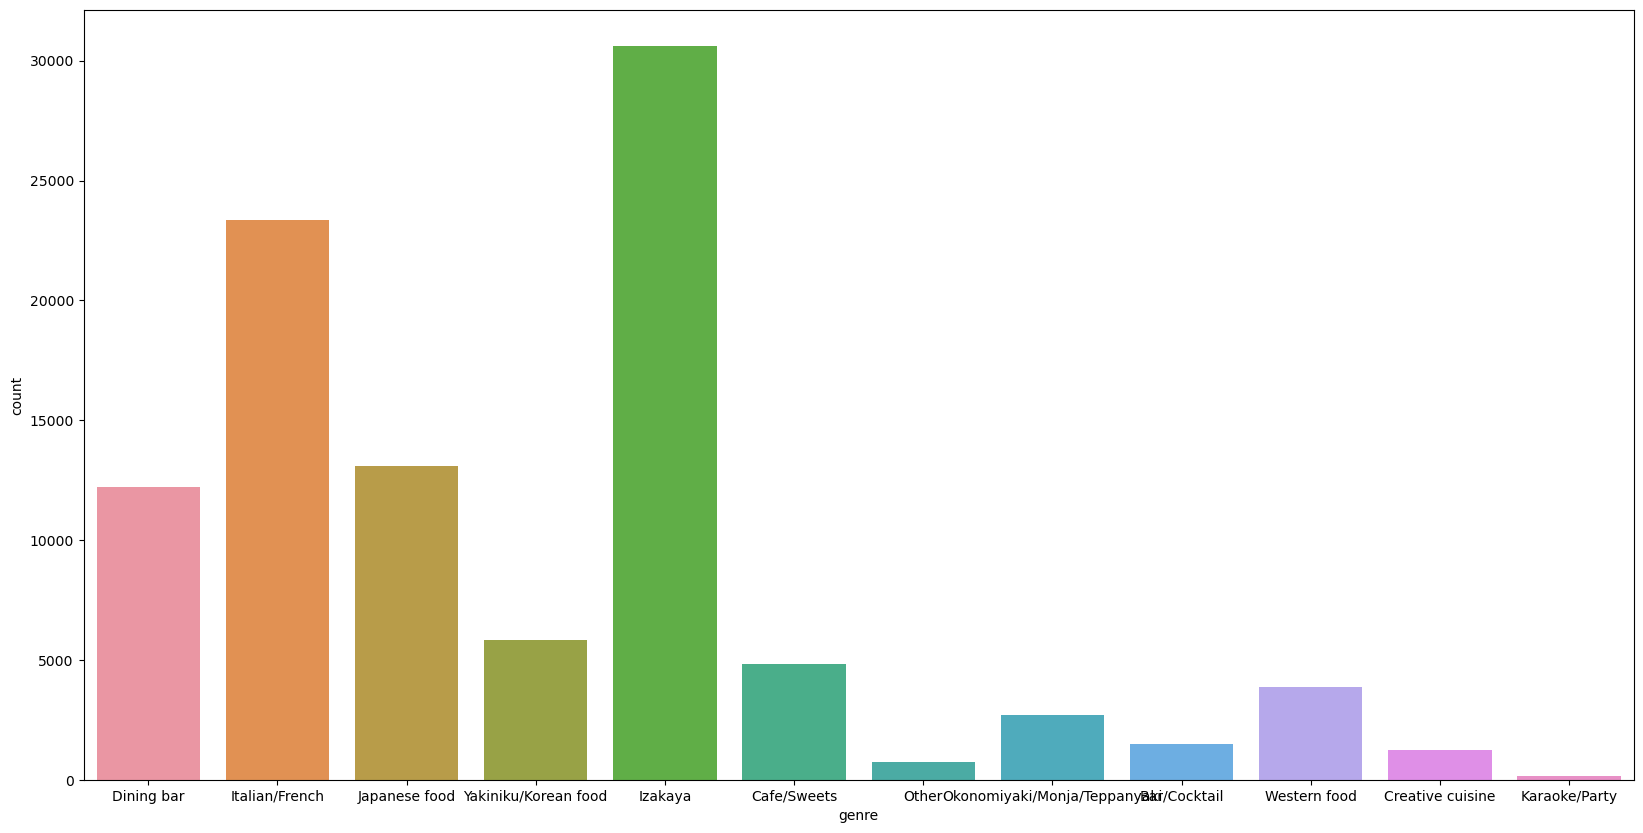

In [76]:
#genre 별 데이터 수 확인
plt.figure(figsize=(20,10))
graph = sns.countplot(x = 'genre', data = X_features)

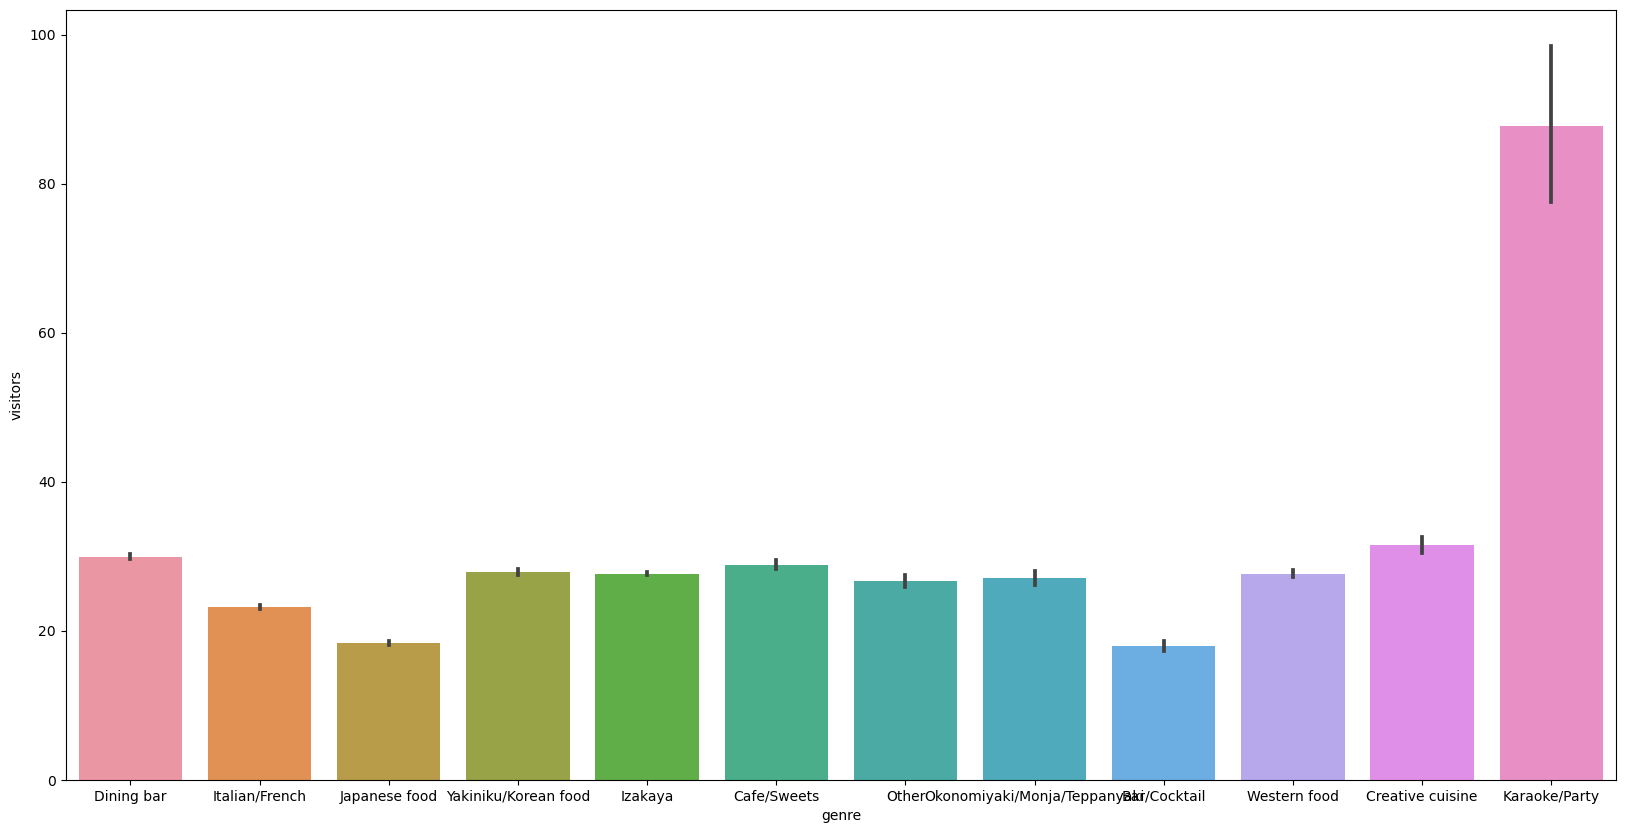

In [77]:
plt.figure(figsize=(20,10))
graph = sns.barplot(x = 'genre', y = 'visitors', data = file_df)
#visitor의 value가 sum이 아닌 count가 되므로 데이터를 다시 정의

In [78]:
#음식장르(genre)별 방문자수(visitors) dataframe 생성
visitor_column = file_df[['genre', 'visitors']]
visitor_column = visitor_column.groupby(by='genre').sum()
visitor_column

,visitors
genre,
Bar/Cocktail,26824
Cafe/Sweets,139805
Creative cuisine,39077
Dining bar,364851
Italian/French,541653
Izakaya,846622
Japanese food,240111
Karaoke/Party,12722
Okonomiyaki/Monja/Teppanyaki,72618


In [79]:
#reset_index로 index였던 genre를 column으로 만들어줌
visitor = visitor_column.reset_index()
visitor

,genre,visitors
0,Bar/Cocktail,26824
1,Cafe/Sweets,139805
2,Creative cuisine,39077
3,Dining bar,364851
4,Italian/French,541653
5,Izakaya,846622
6,Japanese food,240111
7,Karaoke/Party,12722
8,Okonomiyaki/Monja/Teppanyaki,72618
9,Other,20106


<AxesSubplot:xlabel='genre', ylabel='visitors'>

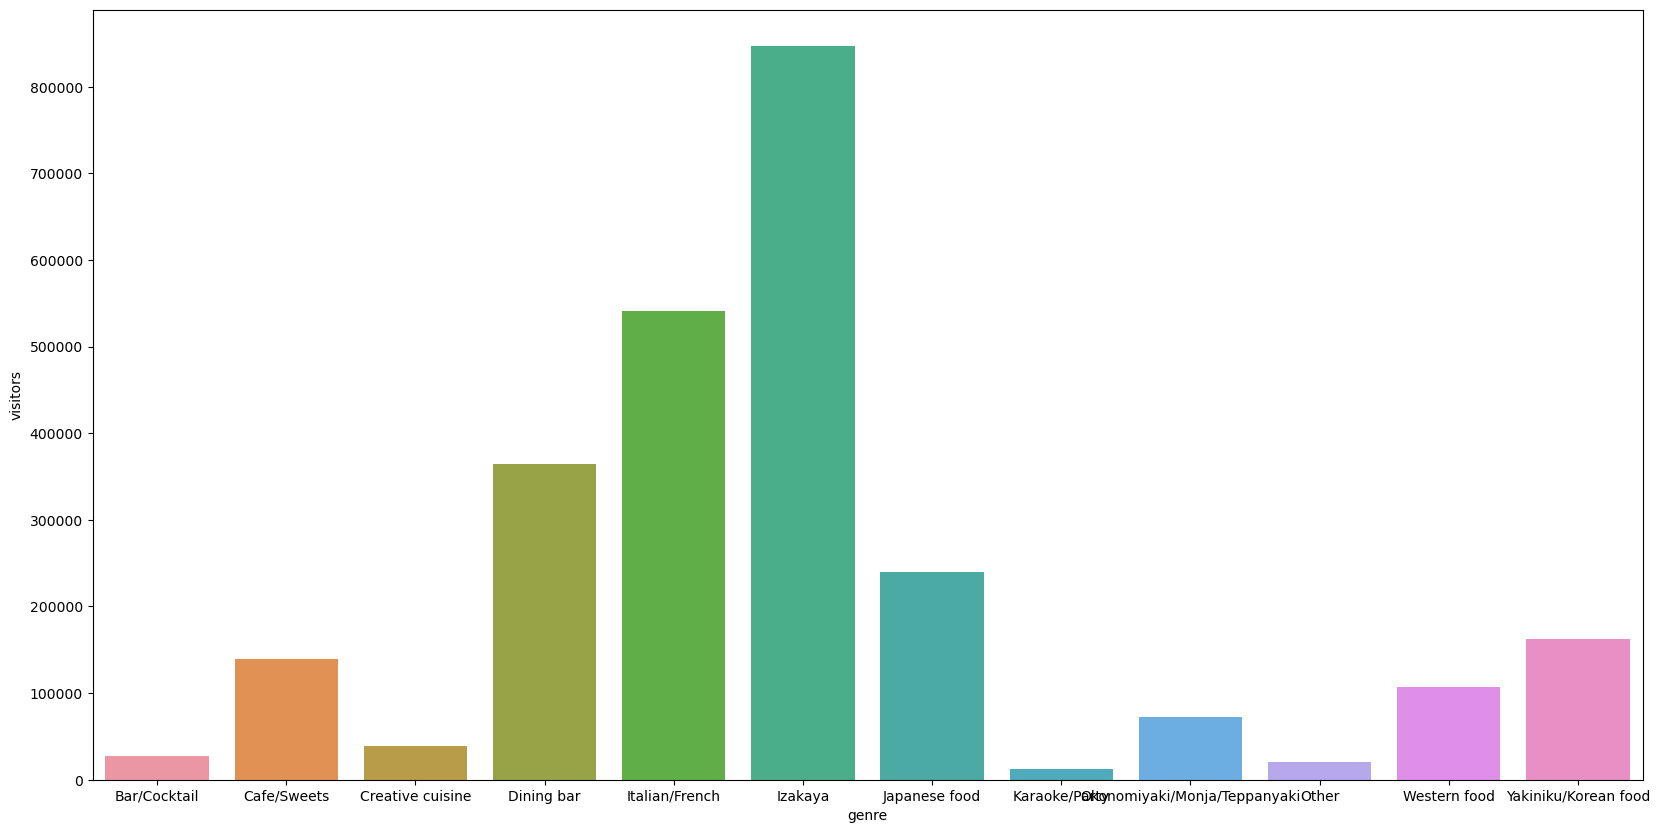

In [80]:
plt.figure(figsize=(20,10))
sns.barplot(x='genre', y='visitors', data = visitor)
# visitor_column.plot(kind='bar', color='orange')

In [81]:
file_df

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
1,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,8.2,9.5,6.0,12.0,3.3
2,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.1,10.4,2.7,12.4,1.6
3,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.3,10.1,2.2,13.2,2.6
4,air_082908692355165e,2016-02-27,27,Italian/French,Tōkyō-to,35.693840,139.703549,2,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100164,air_2a3743e37aab04b4,2016-06-09,7,Italian/French,Ōsaka-fu,34.681261,135.509801,5,Thursday,0,0.0,23.6,4.0,2.3,28.2,21.0
100165,air_2a3743e37aab04b4,2016-06-09,7,Italian/French,Ōsaka-fu,34.681261,135.509801,5,Thursday,0,0.0,23.5,4.8,1.2,28.9,20.0
100166,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,0.0,28.9,10.4,2.3,34.1,24.4
100167,air_2a3743e37aab04b4,2016-07-06,15,Italian/French,Ōsaka-fu,34.681261,135.509801,2,Wednesday,0,0.0,23.9,8.7,2.8,28.9,21.0


In [82]:
#feedback: 시 마다 visitor eda
area_visitor = pd.DataFrame(file_df.groupby(by='area_name')['visitors'].sum())
area_genre_count = pd.DataFrame(file_df.groupby(by='area_name')['genre'].count())
area_genre_visitor = pd.concat([area_visitor, area_genre_count], axis=1)
area_genre_visitor = area_genre_visitor.rename(columns = {'visitors':'visitors_sum', 'genre':'genre_count'})

area_genre_visitor

,visitors_sum,genre_count
area_name,,
Fukuoka-ken,583732,22666
Hiroshima-ken,74439,2786
Hokkaidō,302272,11832
Hyōgo-ken,154613,5529
Miyagi-ken,18486,579
Niigata-ken,75176,2899
Shizuoka-ken,89590,2608
Tōkyō-to,1069407,43812
Ōsaka-fu,207094,7458


In [83]:
area_genre_visitor = area_genre_visitor.reset_index()

In [84]:
area_genre_visitor

,area_name,visitors_sum,genre_count
0,Fukuoka-ken,583732,22666
1,Hiroshima-ken,74439,2786
2,Hokkaidō,302272,11832
3,Hyōgo-ken,154613,5529
4,Miyagi-ken,18486,579
5,Niigata-ken,75176,2899
6,Shizuoka-ken,89590,2608
7,Tōkyō-to,1069407,43812
8,Ōsaka-fu,207094,7458


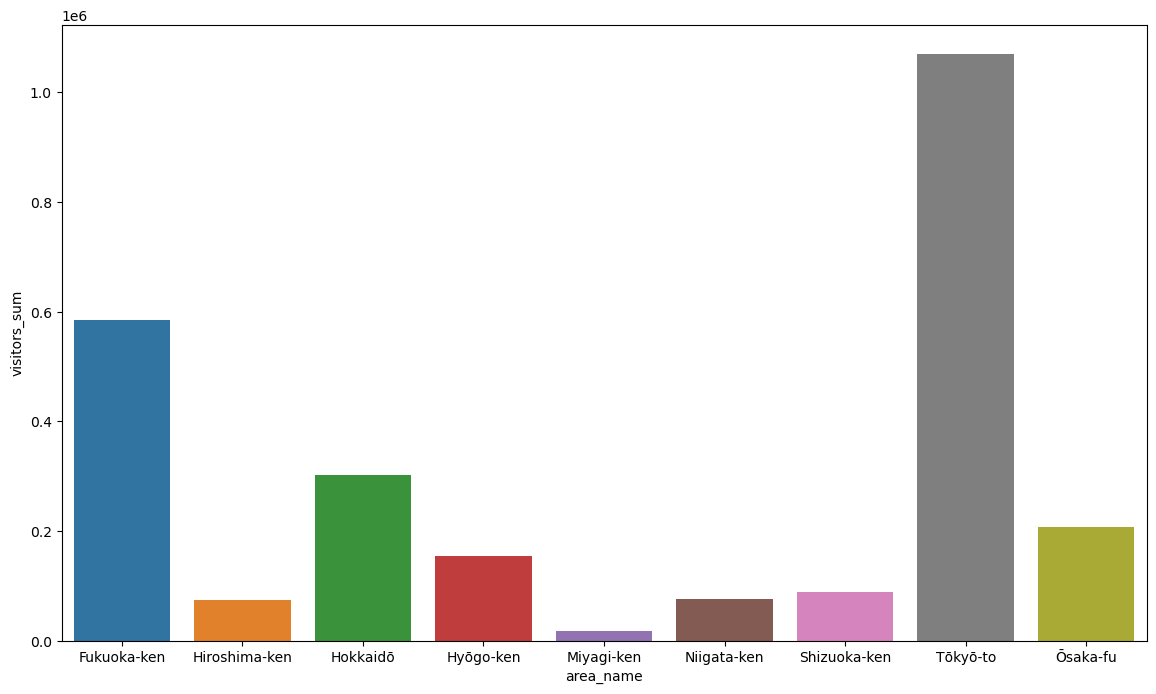

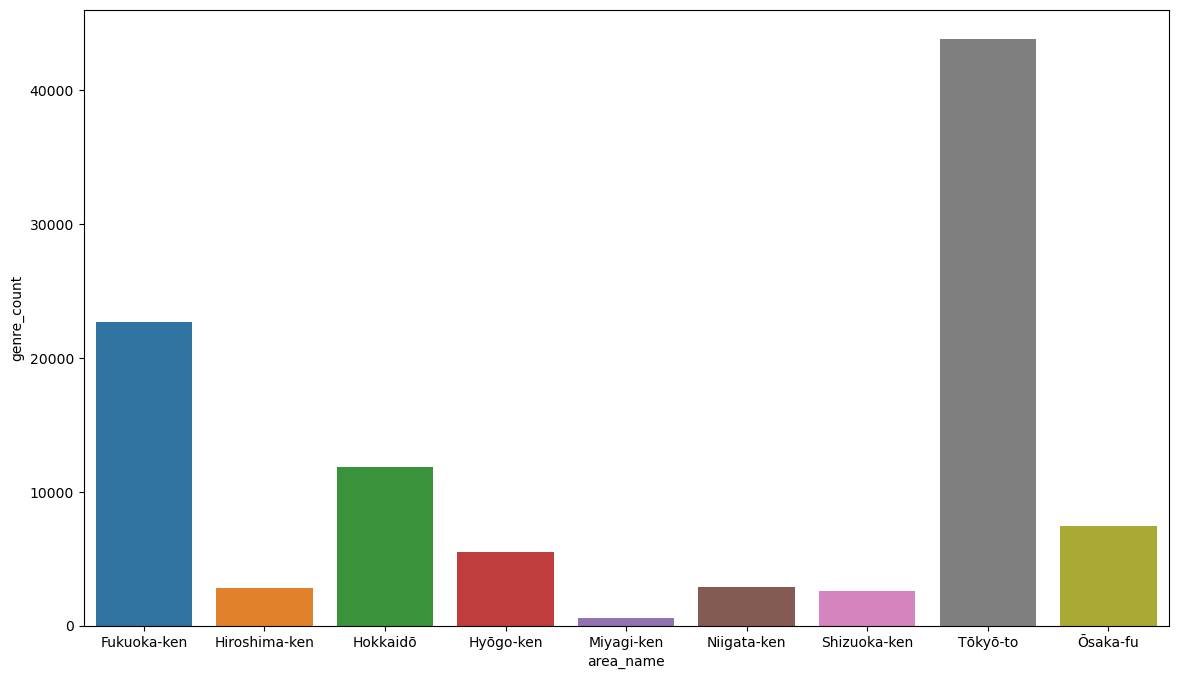

In [85]:
plt.figure(figsize=(14,8))
sns.barplot(x='area_name', y='visitors_sum', data=area_genre_visitor)

plt.figure(figsize=(14,8))
sns.barplot(x='area_name', y='genre_count', data=area_genre_visitor)
plt.show()

In [86]:
#feedback: 시, 지역별로 groupby하여 visitor eda
test111=pd.DataFrame(file_df.groupby(['area_name','genre'])['visitors'].sum())

In [87]:
test111

visitors
area_name     genre                                 
Fukuoka-ken   Cafe/Sweets                      42610
              Creative cuisine                 30060
              Dining bar                       74466
              Italian/French                   57061
              Izakaya                         228949
              Japanese food                   120061
              Other                             2002
              Yakiniku/Korean food             28523
Hiroshima-ken Bar/Cocktail                      1441
              Dining bar                        7146
              Italian/French                    4805
              Izakaya                          50778
              Japanese food                      208
              Okonomiyaki/Monja/Teppanyaki     10061
Hokkaidō      Bar/Cocktail                     15371
              Cafe/Sweets                       9584
              Dining bar                       54929
              Italian/French                   16555
              Izakaya                         108388
              Japanese food                    28720
              Karaoke/Party                    12722
              Western food                     25251
              Yakiniku/Korean food             30752
Hyōgo-ken     Cafe/Sweets                       6129
              Creative cuisine                  6314
              Dining bar                        1096
              Italian/French                   32987
              Izakaya                          84066
              Japanese food                    12390
              Okonomiyaki/Monja/Teppanyaki      2806
              Yakiniku/Korean food              8825
Miyagi-ken    Dining bar                        1822
              Izakaya                          14199
              Japanese food                       42
              Yakiniku/Korean food              2423
Niigata-ken   Izakaya                          62983
              Japanese food                    12193
Shizuoka-ken  Cafe/Sweets                      14576
              Dining bar                       13401
              Italian/French                   25392
              Izakaya                          34082
              Other                             2139
Tōkyō-to      Bar/Cocktail                     10012
              Cafe/Sweets                      64428
              Creative cuisine                  2703
              Dining bar                      134710
              Italian/French                  336192
              Izakaya                         250781
              Japanese food                    66497
              Okonomiyaki/Monja/Teppanyaki     31776
              Other                              396
              Western food                     82264
              Yakiniku/Korean food             89648
Ōsaka-fu      Cafe/Sweets                       2478
              Dining bar                       77281
              Italian/French                   68661
              Izakaya                          12396
              Okonomiyaki/Monja/Teppanyaki     27975
              Other                            15569
              Yakiniku/Korean food              2734

In [88]:
test111.reset_index(inplace = True)

In [89]:
test111

,area_name,genre,visitors
0,Fukuoka-ken,Cafe/Sweets,42610
1,Fukuoka-ken,Creative cuisine,30060
2,Fukuoka-ken,Dining bar,74466
3,Fukuoka-ken,Italian/French,57061
4,Fukuoka-ken,Izakaya,228949
5,Fukuoka-ken,Japanese food,120061
6,Fukuoka-ken,Other,2002
7,Fukuoka-ken,Yakiniku/Korean food,28523
8,Hiroshima-ken,Bar/Cocktail,1441
9,Hiroshima-ken,Dining bar,7146


<AxesSubplot:xlabel='area_name', ylabel='visitors'>

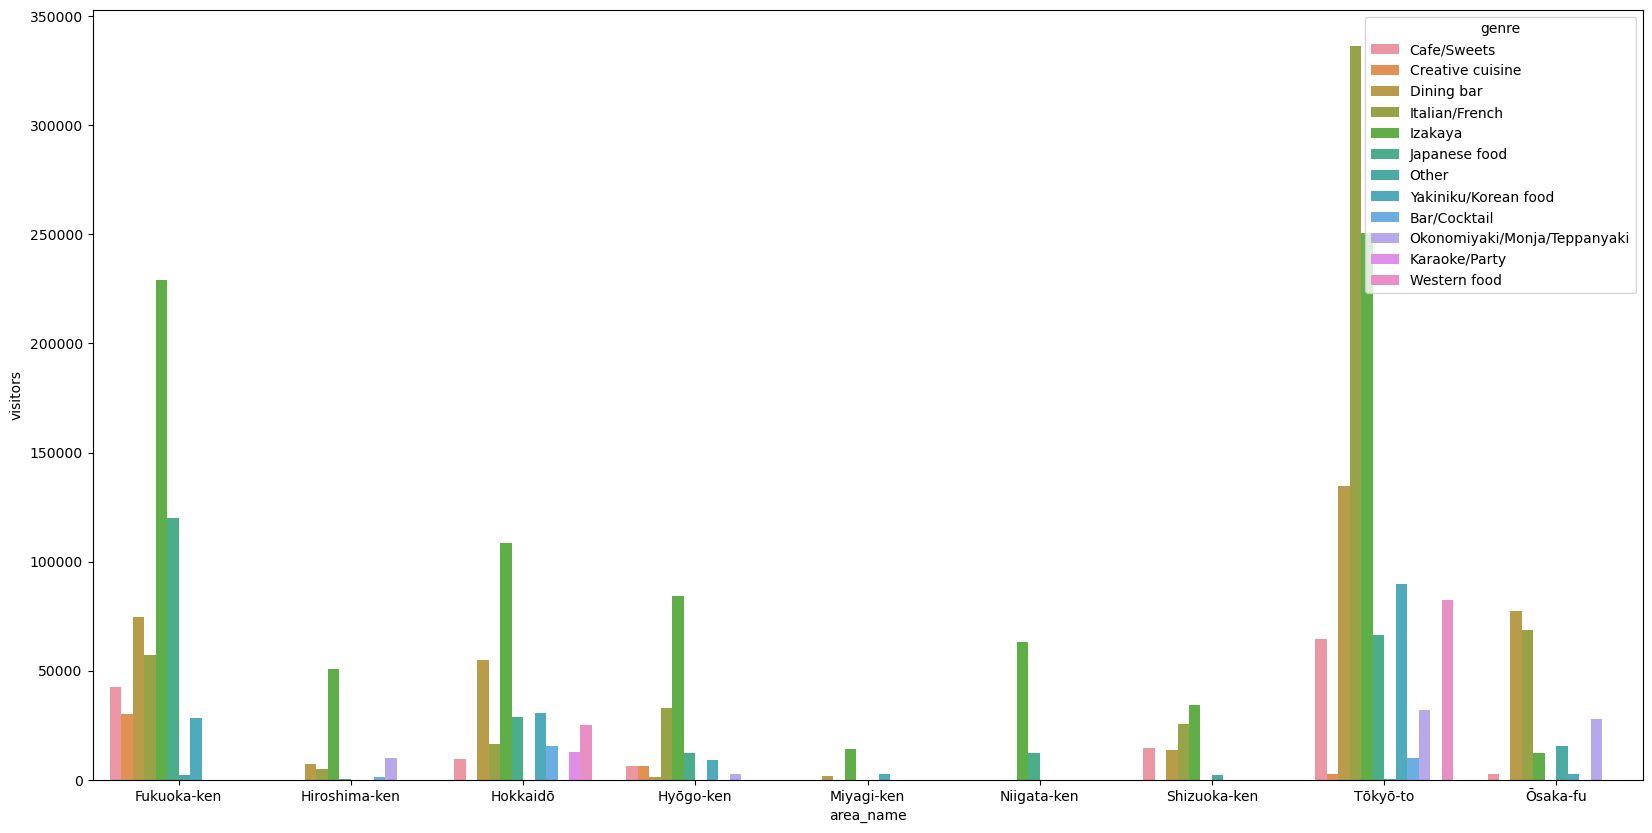

In [90]:
plt.figure(figsize=(20,10))
sns.barplot(x='area_name', y='visitors',hue='genre', data=test111)


## **weather_data 검증**  
kaggle 내 weather 정보 데이터가 실제 데이터와 유사한지

In [91]:
weather_data.head()

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,2016-01-01,0.0,5.7,5.1,1.9,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,2016-01-02,0.5,10.2,1.3,2.2,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,2016-01-03,0.0,11.2,0.5,0.9,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,2016-01-04,0.0,9.4,4.2,1.8,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,2016-01-05,1.5,8.8,0.0,0.8,NaN,12.3,7.1


#### **tokyo weather data 로드**  
출처: 통계청

In [92]:
tokyo_weather = pd.read_csv("../data/tokyo_2017_weather.csv", encoding='euc-kr')
tokyo_weather

,지점,지점명,일시,기온,최고 기온,최저 기온
0,47662,도쿄,2017-01-01 03:00,13.7,NaN,NaN
1,47662,도쿄,2017-01-01 06:00,12.3,NaN,NaN
2,47662,도쿄,2017-01-01 09:00,7.8,NaN,NaN
3,47662,도쿄,2017-01-01 12:00,7.0,13.8,NaN
4,47662,도쿄,2017-01-01 15:00,5.3,NaN,NaN
...,...,...,...,...,...,...
1195,47662,도쿄,2017-05-30 12:00,22.3,29.1,NaN
1196,47662,도쿄,2017-05-30 15:00,22.0,NaN,NaN
1197,47662,도쿄,2017-05-30 18:00,21.8,NaN,NaN
1198,47662,도쿄,2017-05-30 21:00,22.0,NaN,NaN


In [93]:
tokyo_weather['일시'] = pd.to_datetime(tokyo_weather['일시'])
tokyo_weather['일시'] = tokyo_weather['일시'].dt.date
tokyo_weather['일시'] = pd.to_datetime(tokyo_weather['일시'])
tokyo_weather.head()

,지점,지점명,일시,기온,최고 기온,최저 기온
0,47662,도쿄,2017-01-01,13.7,NaN,NaN
1,47662,도쿄,2017-01-01,12.3,NaN,NaN
2,47662,도쿄,2017-01-01,7.8,NaN,NaN
3,47662,도쿄,2017-01-01,7.0,13.8,NaN
4,47662,도쿄,2017-01-01,5.3,NaN,NaN


#### weather data와 tokyo_weather를 비교하기 위해 **weather에서 2017년과 도쿄만 남긴 valid data 생성**

In [94]:
weather_valid = weather_data.copy()
weather_valid['year'] = weather_valid['visit_date'].dt.year
weather_valid.tail()

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature,year
33083,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-27,NaN,19.2,13.5,2.3,1012.5,23.6,14.3,2017
33084,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-28,NaN,21.3,12.6,2.3,1014.2,28.0,15.7,2017
33085,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-29,NaN,23.2,12.8,3.7,1012.8,27.7,19.2,2017
33086,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-30,NaN,23.6,12.1,2.4,1010.6,28.8,19.4,2017
33087,yamaguchi__shimonoseki-kana__shimonoseki,2017-05-31,0.0,23.0,3.1,1.5,1005.4,26.5,20.9,2017


In [95]:
weather_valid = weather_valid[(weather_valid['year']==2017) & weather_valid.area_name.str.contains('tokyo')]
weather_valid.head(3)

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature,year
28284,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,0.0,7.8,9.5,2.5,NaN,13.0,3.4,2017
28285,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-02,0.0,7.7,6.6,1.4,NaN,13.5,3.3,2017
28286,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-03,0.0,8.5,9.2,2.5,NaN,13.8,2.3,2017


In [96]:
#weather_valid와 tokyo_weather 시계열 그래프 그리기

#1. 먼저 데이터를 합침
weather_merge = pd.merge(weather_valid, tokyo_weather, left_on='visit_date', right_on='일시')
weather_merge.head(3)

,area_name,visit_date,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,avg_sea_pressure,high_temperature,low_temperature,year,지점,지점명,일시,기온,최고 기온,최저 기온
0,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,0.0,7.8,9.5,2.5,NaN,13.0,3.4,2017,47662,도쿄,2017-01-01,13.7,NaN,NaN
1,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,0.0,7.8,9.5,2.5,NaN,13.0,3.4,2017,47662,도쿄,2017-01-01,12.3,NaN,NaN
2,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,0.0,7.8,9.5,2.5,NaN,13.0,3.4,2017,47662,도쿄,2017-01-01,7.8,NaN,NaN


In [97]:
#2. 필요없는 column drop, 여기선 기온만 볼거니깐 나머지 다 드롭
weather_merge = weather_merge[['area_name', 'visit_date','avg_temperature','기온']]
weather_merge

,area_name,visit_date,avg_temperature,기온
0,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,13.7
1,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,12.3
2,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,7.8
3,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,7.0
4,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,5.3
...,...,...,...,...
10795,tokyo__nerima-kana__nerima,2017-05-31,24.0,25.5
10796,tokyo__ome-kana__NONE,2017-05-31,23.5,25.5
10797,tokyo__setagaya-kana__setagaya,2017-05-31,NaN,25.5
10798,tokyo__tokyo-kana__tonokyo,2017-05-31,23.6,25.5


In [98]:
#3. 월 별로 그래프를 그리기 위해 weather_merge의 visit_date를 월까지만 표시해보자
weather_merge['year-month']= weather_merge['visit_date'].dt.strftime('%Y-%m')
weather_merge.head()

,area_name,visit_date,avg_temperature,기온,year-month
0,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,13.7,2017-01
1,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,12.3,2017-01
2,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,7.8,2017-01
3,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,7.0,2017-01
4,tokyo__edogawa-seaside-kana__edgawawinkai,2017-01-01,7.8,5.3,2017-01


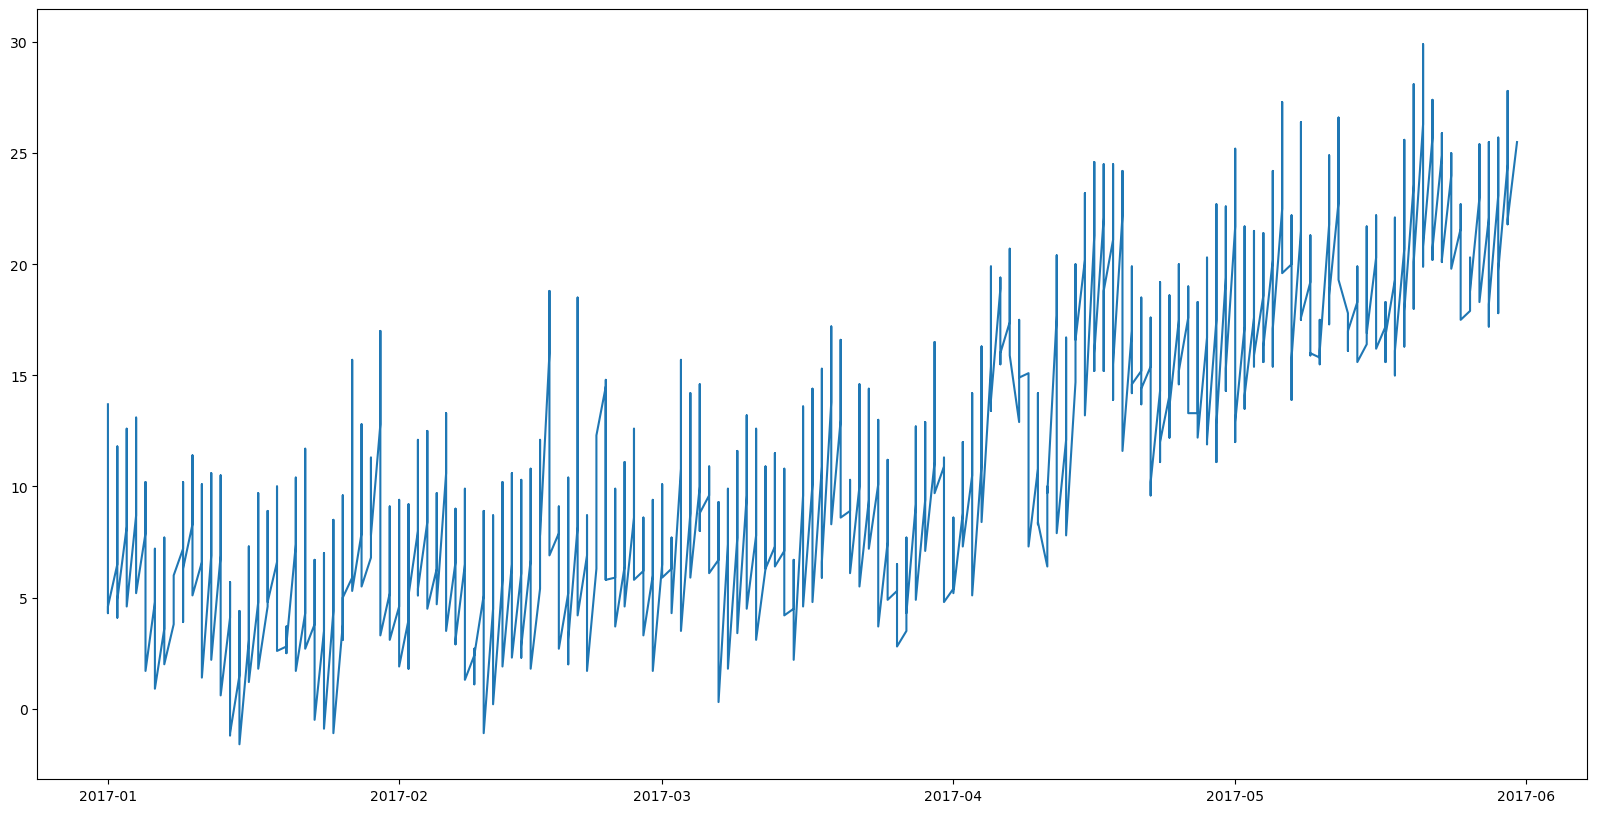

In [99]:
plt.figure(figsize=(20,10))
plt.plot(weather_merge['visit_date'], weather_merge['기온'])

#### 왜 이상할까? visit_date 부분의 데이터를 잘 살펴보자

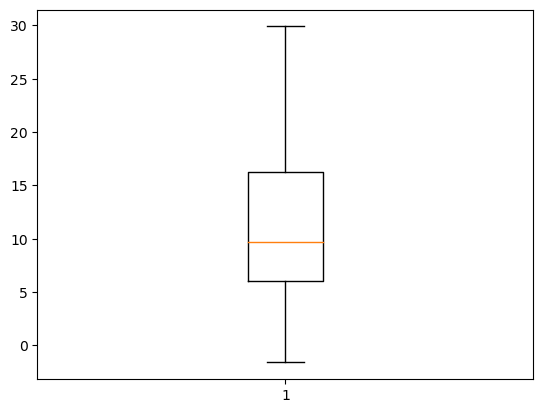

In [100]:
#기온의 이상치를 확인해보자
plt.boxplot(weather_merge['기온'])
plt.show()

In [101]:
#weather_merge의 info를 확인, 기온의 타입을 보자
weather_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10800 entries, 0 to 10799
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   area_name        10800 non-null  object        
 1   visit_date       10800 non-null  datetime64[ns]
 2   avg_temperature  8400 non-null   float64       
 3   기온               10800 non-null  float64       
 4   year-month       10800 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 506.2+ KB


In [102]:
#날짜를 기준으로 avg_temperature(기존 weather_data), 기온(tokyo_weather)를 groupby.
test112 = weather_merge.groupby(['visit_date'])['avg_temperature','기온'].mean()

#reset_index를 통해 index열을 column화 한다.
test112 = test112.reset_index()
test112

C:\Users\piai\AppData\Local\Temp\ipykernel_2328\565753957.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test112 = weather_merge.groupby(['visit_date'])['avg_temperature','기온'].mean()


,visit_date,avg_temperature,기온
0,2017-01-01,6.985714,7.857143
1,2017-01-02,6.985714,7.325000
2,2017-01-03,7.457143,8.250000
3,2017-01-04,7.771429,8.637500
4,2017-01-05,6.114286,5.712500
...,...,...,...
146,2017-05-27,20.028571,20.950000
147,2017-05-28,20.542857,20.950000
148,2017-05-29,21.171429,21.762500
149,2017-05-30,23.000000,24.075000


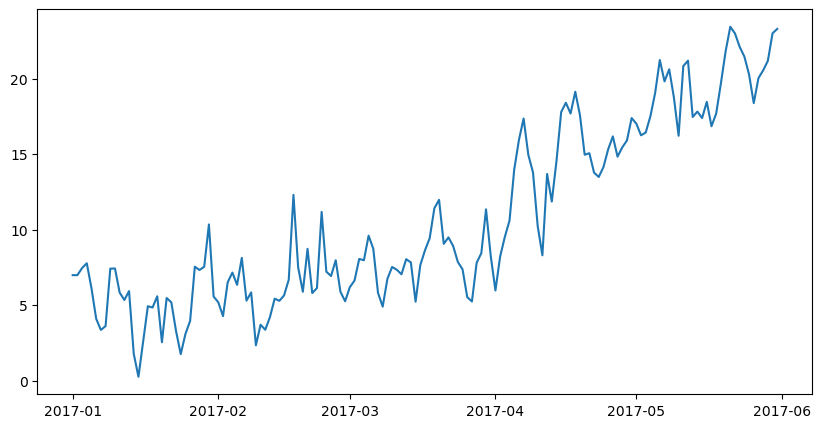

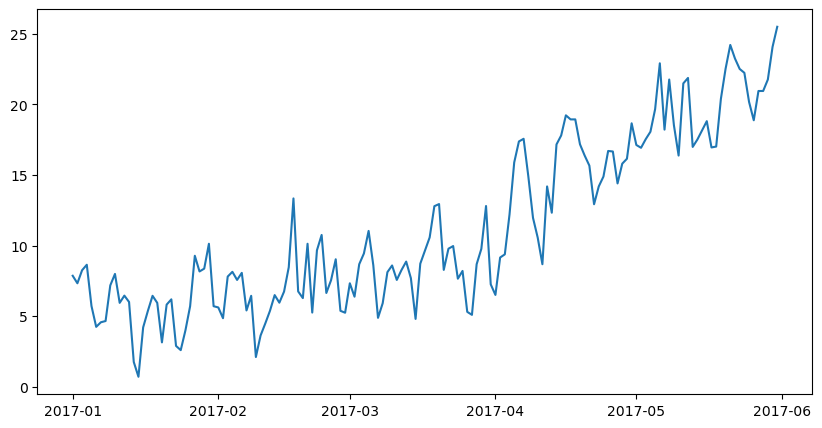

In [103]:
#4. 월 기준 시계열 그래프 그려보자
plt.figure(figsize=(10,5))
plt.plot(test112['visit_date'],test112['avg_temperature'])

plt.figure(figsize=(10,5))
plt.plot(test112['visit_date'],test112['기온'])


plt.show()

In [104]:
#5. 두 그래프를 중첩시켜서 비교해보자. 다시 묶고 이번엔 reset_index를 하지 않음
test113 = weather_merge.groupby(['visit_date'])['avg_temperature','기온'].mean()
test113

C:\Users\piai\AppData\Local\Temp\ipykernel_2328\1805265749.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test113 = weather_merge.groupby(['visit_date'])['avg_temperature','기온'].mean()


,avg_temperature,기온
visit_date,,
2017-01-01,6.985714,7.857143
2017-01-02,6.985714,7.325000
2017-01-03,7.457143,8.250000
2017-01-04,7.771429,8.637500
2017-01-05,6.114286,5.712500
...,...,...
2017-05-27,20.028571,20.950000
2017-05-28,20.542857,20.950000
2017-05-29,21.171429,21.762500


<AxesSubplot:xlabel='visit_date'>

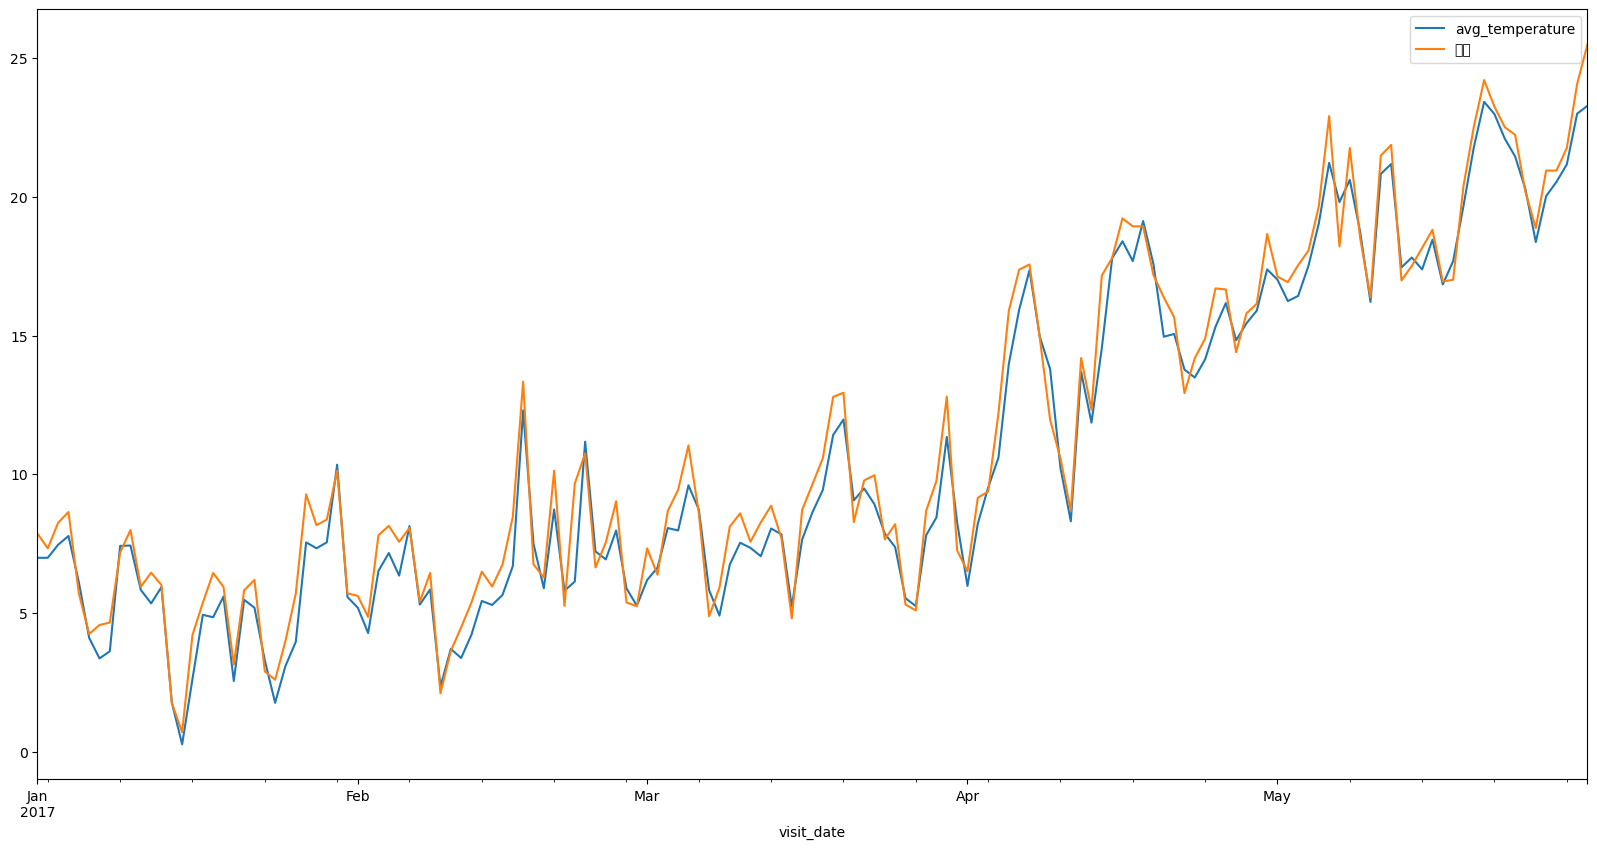

In [105]:
import warnings
warnings.filterwarnings(action='ignore')
test113['2017'].plot(figsize=(20,10))

## **ARIMA 적용**  
### **df = file_ df 해놓기**  
편의성을 위해

In [106]:
df = file_df

In [107]:
#같은 지역, 같은 날짜, 다른 가게 > 전체 visitor 확인
print(df['area_name'].unique())
print(df['area_name'].nunique())

['Tōkyō-to' 'Shizuoka-ken' 'Hiroshima-ken' 'Hyōgo-ken' 'Hokkaidō'
 'Fukuoka-ken' 'Niigata-ken' 'Ōsaka-fu' 'Miyagi-ken']
9


In [108]:
df.head()

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
0,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3
1,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,8.2,9.5,6.0,12.0,3.3
2,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.1,10.4,2.7,12.4,1.6
3,air_35512c42db0868da,2016-02-27,6,Dining bar,Tōkyō-to,35.717784,139.566260,12,Saturday,0,0.0,7.3,10.1,2.2,13.2,2.6
4,air_082908692355165e,2016-02-27,27,Italian/French,Tōkyō-to,35.693840,139.703549,2,Saturday,0,0.0,6.2,10.5,3.8,10.9,0.3


In [109]:
df2 = pd.DataFrame(df.groupby(['area_name','visit_date','air_store_id'])['visitors'].sum())
df2

visitors
area_name   visit_date air_store_id                  
Fukuoka-ken 2016-01-02 air_789466e488705c93       408
            2016-01-03 air_6c91a28278a16f64       144
            2016-01-04 air_24b9b2a020826ede        44
                       air_2d3afcb91762fe01       268
                       air_622375b4815cf5cb       136
...                                               ...
Ōsaka-fu    2017-04-22 air_670a0c1c4108bcea        84
                       air_7420042ff75f9aca       156
                       air_c6a164dd4060e960        57
                       air_db4b38ebe7a7ceff        57
                       air_dea0655f96947922       192

[26491 rows x 1 columns]

In [110]:
#tokyo지역만 데이터 추출
df_tokyo = df[df['area_name'].str.contains('Tōkyō')]
df_tokyo = df_tokyo[['air_store_id', 'visit_date', 'visitors','avg_temperature']]

### **ARIMA**

In [111]:
#필요모듈 불러오기
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima.arima import auto_arima
import math

import itertools

In [112]:
#평가지표
from sklearn import metrics

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true,y_pred) #MAE
def mse(y_true, y_pred):
    return metrics.mean_squared_error(y_true,y_pred) # MSE
def rmse(y_true, y_pred):    
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))  # RMSE
def r2(y_true, y_pred):    
    return metrics.r2_score(y_true,y_pred) # R2
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100 # MAPE

def get_score(model, y_true, y_pred):
    model = model
    mae_val = mae(y_true, y_pred)
    mse_val = mse(y_true, y_pred)
    rmse_val = rmse(y_true, y_pred)
    r2_val = r2(y_true, y_pred)
    mape_val = mape(y_true, y_pred)
    
    score_dict = {"model": model,
                  "mae" :  mae_val,
                  "mse" :  mse_val,
                  "rmse" : rmse_val,
                  "r2":    r2_val, 
                  "mape" : mape_val
                 }
    return score_dict

In [114]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

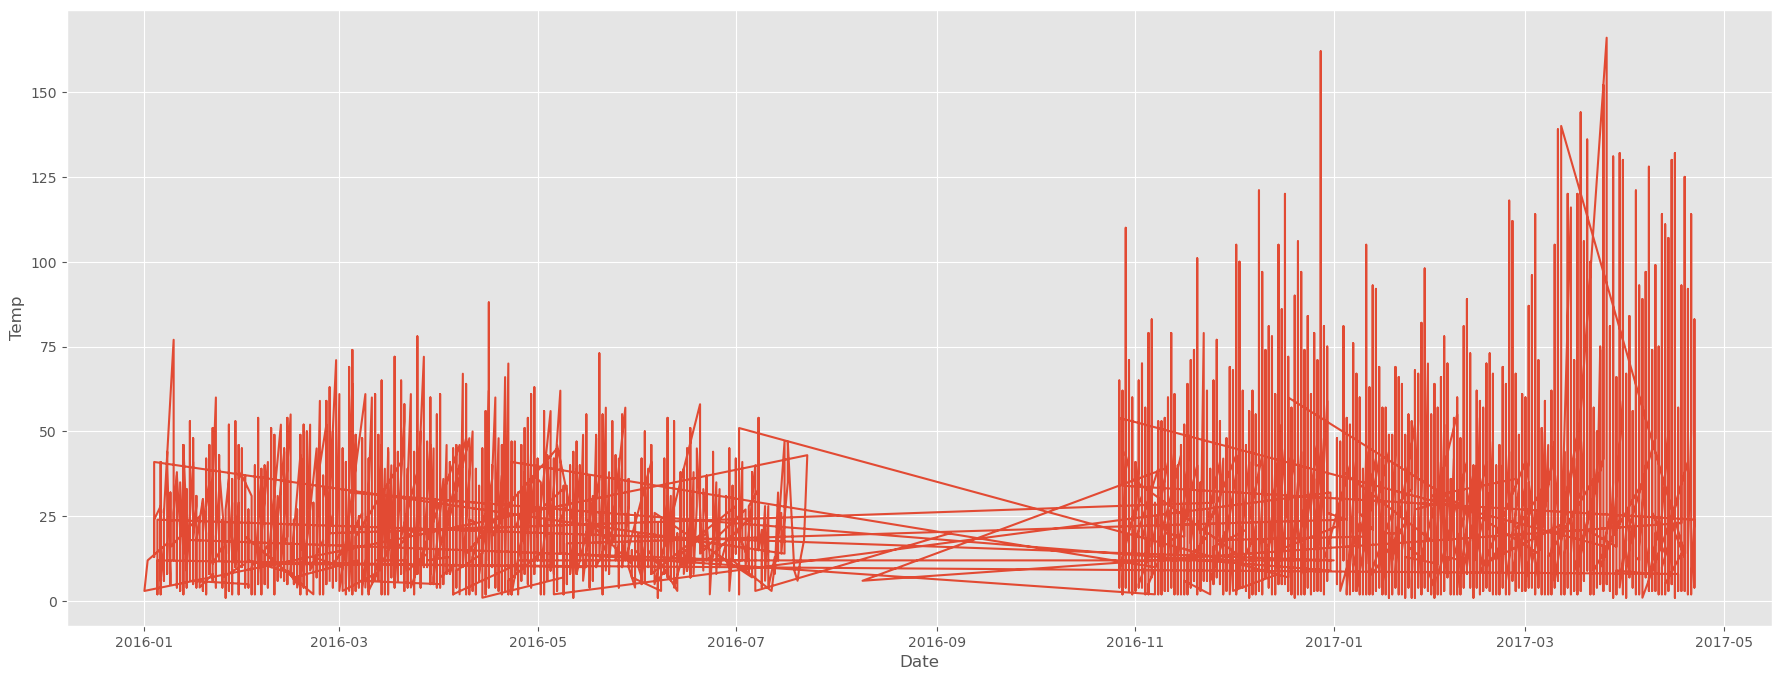

In [115]:
plt.figure(figsize=(22,8))
plt.plot(df_tokyo.visit_date, df_tokyo.visitors)
plt.xlabel("Date")
plt.ylabel("Temp")
plt.show()

In [116]:
#tokyo 중 가장 데이터가 많은 가게 찾기
df_tokyo.air_store_id.mode()

0    air_8093d0b565e9dbdf
Name: air_store_id, dtype: object

In [117]:
df_tokyo[df_tokyo.air_store_id == 'air_8093d0b565e9dbdf']

,air_store_id,visit_date,visitors,avg_temperature
32,air_8093d0b565e9dbdf,2016-02-27,29,6.2
33,air_8093d0b565e9dbdf,2016-02-27,29,8.2
34,air_8093d0b565e9dbdf,2016-02-27,29,7.1
35,air_8093d0b565e9dbdf,2016-02-27,29,7.3
3105,air_8093d0b565e9dbdf,2016-11-25,56,3.2
...,...,...,...,...
99138,air_8093d0b565e9dbdf,2016-04-05,28,10.8
99181,air_8093d0b565e9dbdf,2016-04-25,32,16.8
99182,air_8093d0b565e9dbdf,2016-04-25,32,17.8
99183,air_8093d0b565e9dbdf,2016-04-25,32,17.6


In [118]:
df[df.air_store_id == 'air_8093d0b565e9dbdf'].tail(10)

,air_store_id,visit_date,visitors,genre,area_name,latitude,longitude,reserve_visitors,day_of_week,holiday_flg,precipitation,avg_temperature,hours_sunlight,avg_wind_speed,high_temperature,low_temperature
99098,air_8093d0b565e9dbdf,2016-04-04,10,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,7,Monday,0,8.0,15.6,0.7,3.2,21.9,9.7
99134,air_8093d0b565e9dbdf,2016-04-05,28,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,19,Tuesday,0,2.5,9.5,0.0,1.5,11.7,7.2
99135,air_8093d0b565e9dbdf,2016-04-05,28,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,19,Tuesday,0,1.0,10.9,0.0,2.1,12.3,9.0
99136,air_8093d0b565e9dbdf,2016-04-05,28,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,19,Tuesday,0,3.5,10.3,0.0,1.4,12.3,7.5
99137,air_8093d0b565e9dbdf,2016-04-05,28,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,19,Tuesday,0,2.5,10.7,0.0,0.9,13.3,8.9
99138,air_8093d0b565e9dbdf,2016-04-05,28,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,19,Tuesday,0,1.5,10.8,0.0,2.1,12.8,9.1
99181,air_8093d0b565e9dbdf,2016-04-25,32,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,26,Monday,0,0.0,16.8,8.1,2.0,22.3,12.1
99182,air_8093d0b565e9dbdf,2016-04-25,32,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,26,Monday,0,0.0,17.8,8.3,3.0,22.6,13.7
99183,air_8093d0b565e9dbdf,2016-04-25,32,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,26,Monday,0,0.0,17.6,8.8,1.8,22.8,13.3
99184,air_8093d0b565e9dbdf,2016-04-25,32,Yakiniku/Korean food,Tōkyō-to,35.672114,139.770825,26,Monday,0,0.0,18.1,8.5,1.0,23.2,13.5


#### **id = air_8093d0b565e9dbdf 인 가게가 데이터가 많으므로 이걸 기준으로 시계열분석을 해보자**

In [119]:
test_tokyo = df_tokyo[df_tokyo.air_store_id == 'air_8093d0b565e9dbdf']

In [120]:
#중복행이 많으니 먼저 제거를 해주자
test_tokyo = test_tokyo.drop_duplicates(['visit_date'])

In [121]:
test_tokyo.reset_index(inplace=True)
test_tokyo

,index,air_store_id,visit_date,visitors,avg_temperature
0,32,air_8093d0b565e9dbdf,2016-02-27,29,6.2
1,3105,air_8093d0b565e9dbdf,2016-11-25,56,3.2
2,3315,air_8093d0b565e9dbdf,2016-12-05,23,11.3
3,18644,air_8093d0b565e9dbdf,2016-10-31,40,12.2
4,18886,air_8093d0b565e9dbdf,2016-11-02,57,9.7
...,...,...,...,...,...
295,98997,air_8093d0b565e9dbdf,2016-03-22,39,8.6
296,99049,air_8093d0b565e9dbdf,2016-03-28,28,10.2
297,99094,air_8093d0b565e9dbdf,2016-04-04,10,13.5
298,99134,air_8093d0b565e9dbdf,2016-04-05,28,9.5


In [127]:
#visit_date기준으로 정렬을 해주자
test_tokyo = test_tokyo.sort_values('visit_date')
test_tokyo.drop(['index'], axis=1, inplace=True)

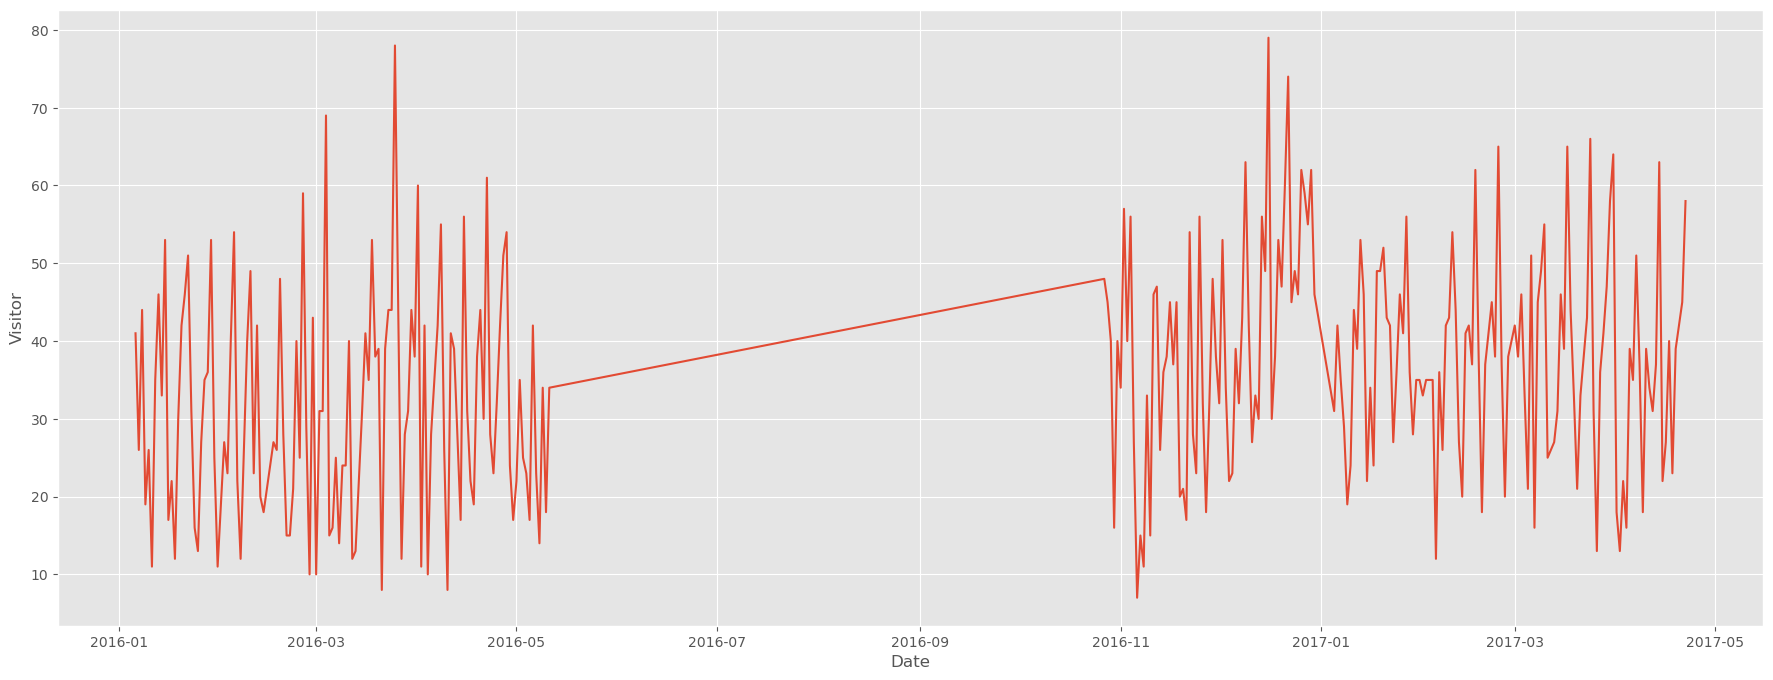

In [123]:
#도쿄의 가게 하나의 방문자수 추이
plt.figure(figsize=(22,8))
plt.plot(test_tokyo.visit_date, test_tokyo.visitors)
plt.xlabel("Date")
plt.ylabel("Visitor")
plt.show()

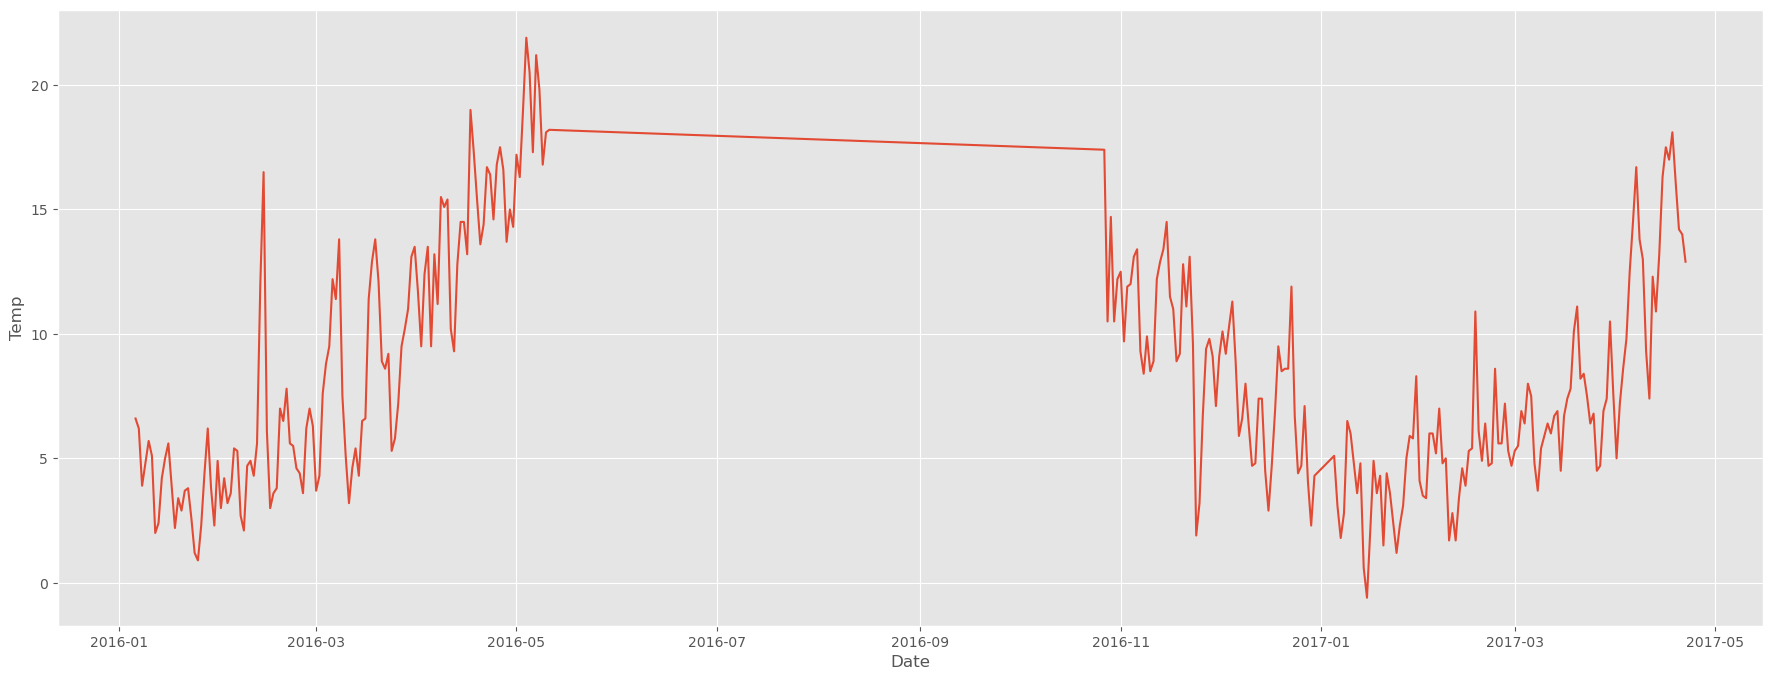

In [124]:
#도쿄의 기온 추이
plt.figure(figsize=(22,8))
plt.plot(test_tokyo.visit_date, test_tokyo.avg_temperature)
plt.xlabel("Date")
plt.ylabel("Temp")
plt.show()

In [128]:
# ArmaProcess로 모형 생성하고 nobs 만큼 샘플 생성
def gen_arma_samples (ar,ma,nobs):
    arma_model   = ArmaProcess(ar=ar, ma=ma)        # 모형 정의
    arma_samples = arma_model.generate_sample(nobs) # 샘플 생성
    return arma_samples

In [199]:
#id = air_8093d0b565e9dbdf인 가게의 tokyo.visitors dataframe 따로 만들기
test_tokyo_visitors = test_tokyo[['visit_date','visitors']]
test_tokyo_visitors.reset_index(inplace=True, drop=True)
test_tokyo_visitors

,visit_date,visitors
0,2016-01-06,41
1,2016-01-07,26
2,2016-01-08,44
3,2016-01-09,19
4,2016-01-10,26
...,...,...
295,2017-04-18,23
296,2017-04-19,39
297,2017-04-20,42
298,2017-04-21,45


In [200]:
#빈 데이터 때문에 데이터를 잘라준다
test_tokyo_visitors = test_tokyo_visitors.iloc[127:]
test_tokyo_visitors.head()

,visit_date,visitors
127,2016-10-27,48
128,2016-10-28,45
129,2016-10-29,40
130,2016-10-30,16
131,2016-10-31,40


In [201]:
#데이터프레임 새로 생성: ACE, PCAF 그래프를 그리기 위해 visit_date를 set_index해준다.
st_tokyo_visitors = test_tokyo_visitors.set_index('visit_date')
st_tokyo_visitors

,visitors
visit_date,
2016-10-27,48
2016-10-28,45
2016-10-29,40
2016-10-30,16
2016-10-31,40
...,...
2017-04-18,23
2017-04-19,39
2017-04-20,42


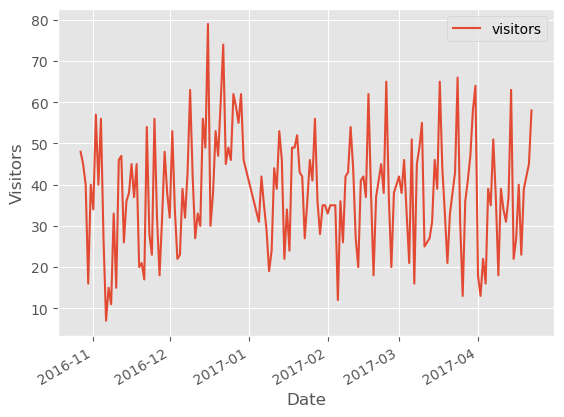

In [202]:
#기간 설정한 가게의 방문자추이
st_tokyo_visitors.plot()
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.show()

#### **시계열 성분 분해**

<Figure size 640x480 with 0 Axes>

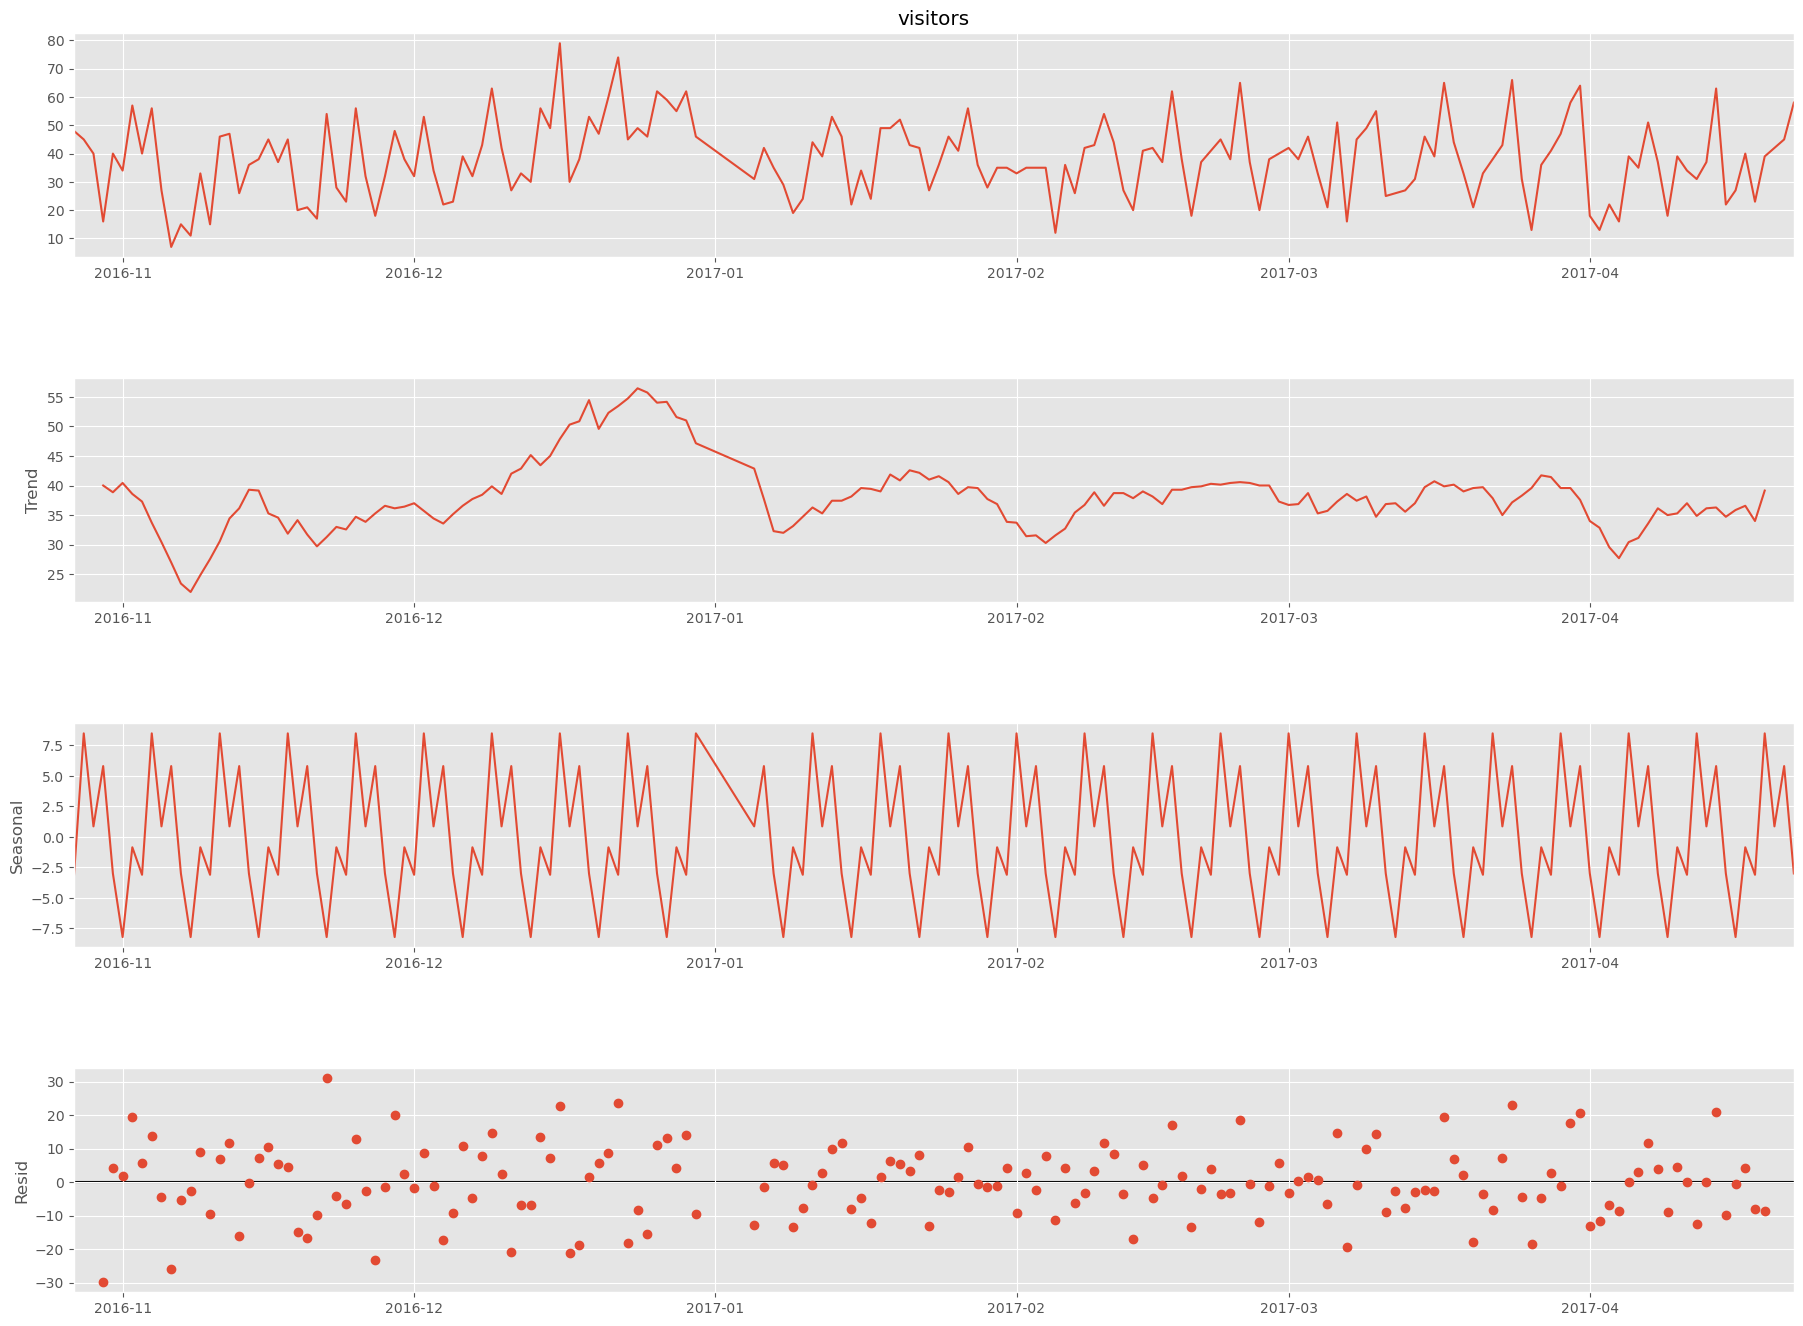

In [203]:
#seasonal_decompose()
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(x=st_tokyo_visitors['visitors'], model='additive',period=7)

fig=plt.figure()
fig=result.plot()
fig.set_size_inches(20,15)

### **ACE, PACF plot**

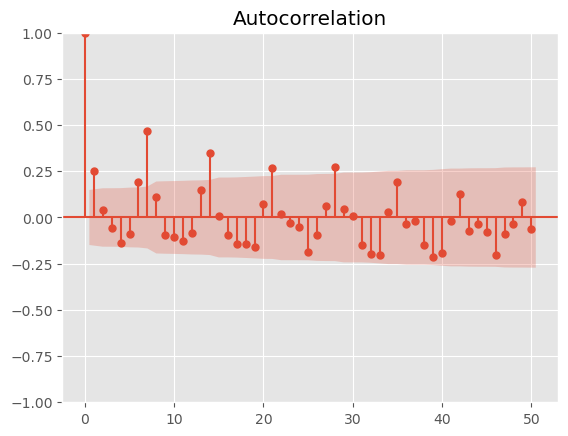

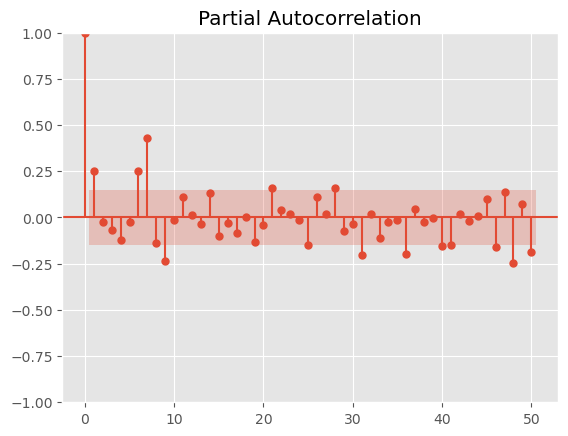

In [204]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(st_tokyo_visitors, lags=50)
plot_pacf(st_tokyo_visitors, lags=50)
plt.show()

#### **모형구축**

In [216]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(st_tokyo_visitors, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               visitors   No. Observations:                  173
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -690.327
Date:                Wed, 14 Dec 2022   AIC                           1386.655
Time:                        11:29:13   BIC                           1396.115
Sample:                             0   HQIC                          1390.492
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.2311      1.343     28.474      0.000      35.599      40.863
ar.L1          0.2522      0.074      3.389      0.001       0.106       0.398
sigma2       171.1289     20.510      8.344      0.0

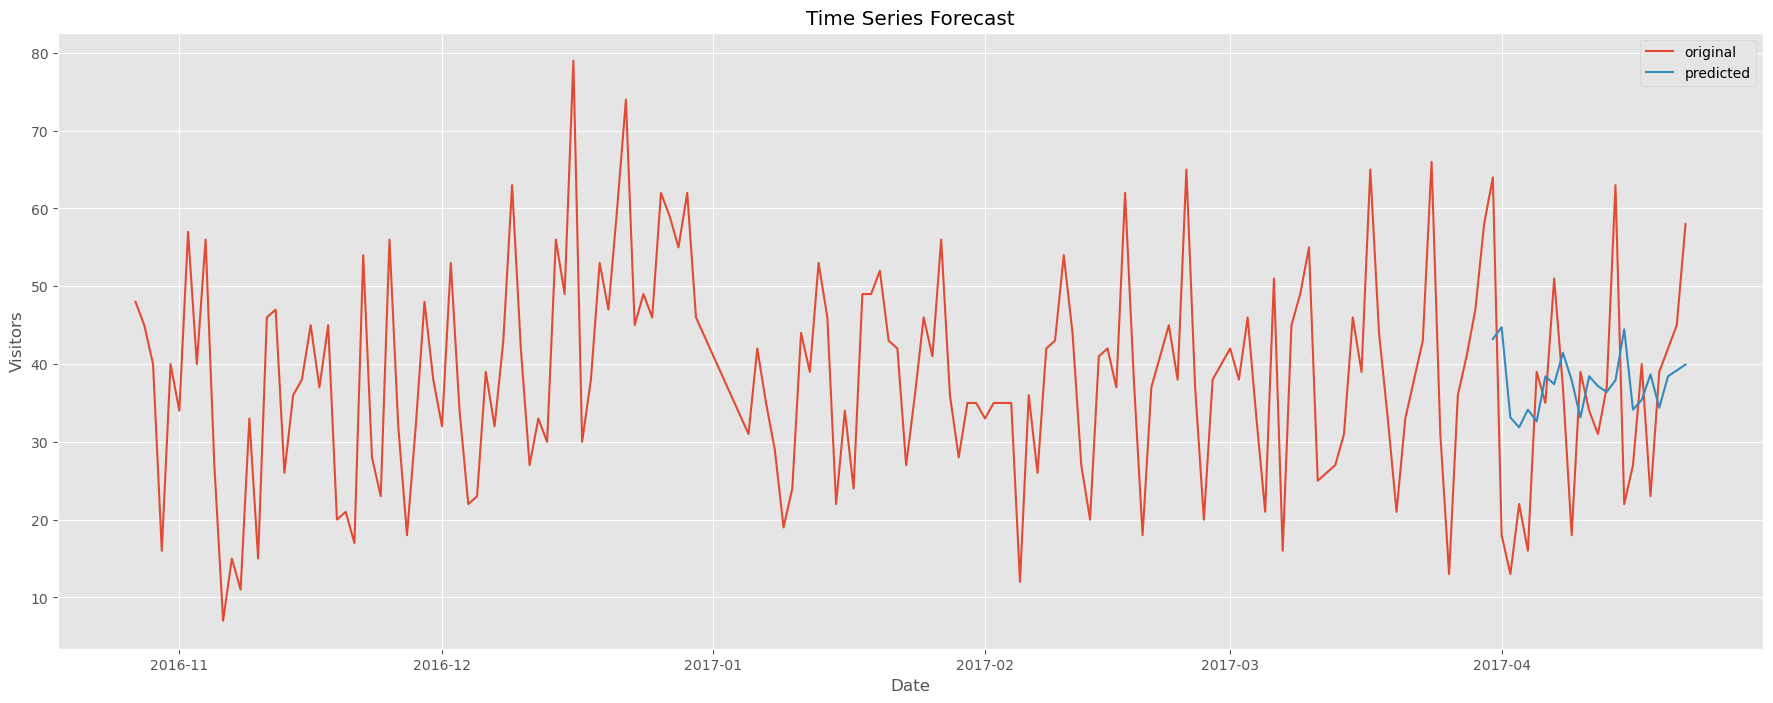

In [217]:
from pandas import datetime

#predict
start_index=datetime(2017,3,31)
end_index=datetime(2017,4,22)
forecast=model_fit.predict(start=start_index, end=end_index, type='levels')

#visualization
plt.figure(figsize=(22,8))
plt.plot(test_tokyo_visitors.visit_date, test_tokyo_visitors.visitors, label='original')
plt.plot(forecast, label="predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Visitors")
plt.legend()
plt.show()


#### 잔차분석

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


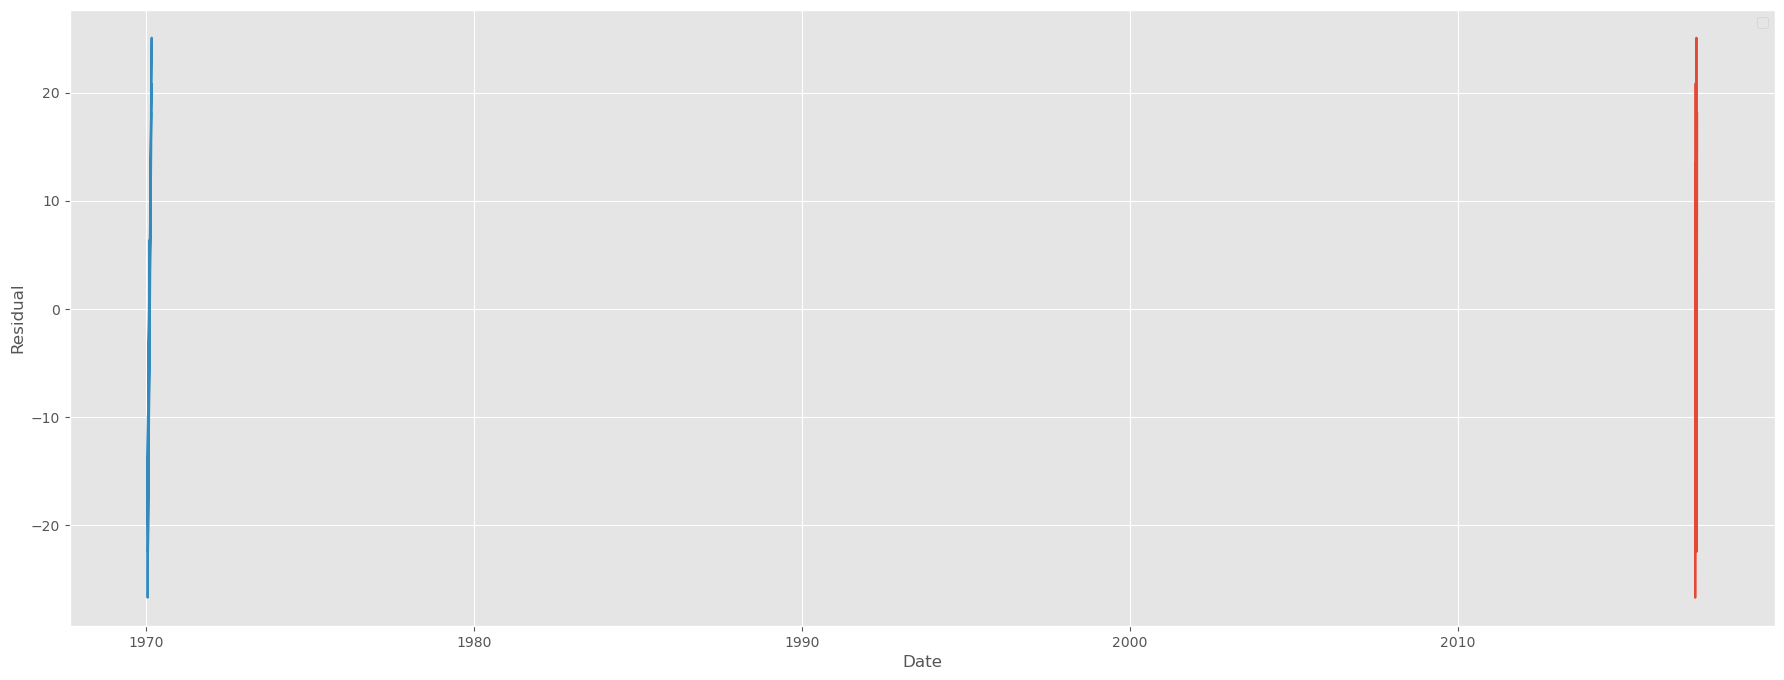

In [218]:
resi = np.array(test_tokyo_visitors[test_tokyo_visitors.visit_date>=start_index].visitors) - np.array(forecast)

plt.figure(figsize=(22,8))
plt.plot(test_tokyo_visitors[test_tokyo_visitors.visit_date>=start_index], resi)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

In [219]:
start_index

datetime.datetime(2017, 3, 31, 0, 0)